# Elevator/ML Experiment: Analyzing trained ML models
**This code analyses the trained Machine Learning (ML) models along different stages. All ML models are based on supervised learning, and the different architectures include dense and convolutional layers.**

The original magnetic fields $(B_X, B_Y, B_Z)$ are organized in time windows with fixed number of points, each one correlated with a Z-position label ($Z_{pos}$) that represents the lastest position of the elevator (i.e. the last point of the time window). The magnetic information can be used in the full format, with 3 different channels $Bx,By,Bz$, or it can be reduced to 1 or 2 channels, also introducing the scalar field $|\vec{B}|$.

The ML algorithm predicts the Z-position of the elevator $Z_{pred}(t)$ for all times, which are compared with the ground truth labels $Z_{true}(t)$, and the performance of the ML model is evaluated according to two different metrics. This double-metric criteria originates in the nature of the ground truth labels $Z_{true}(t)$: **our experimental measurements for the elevator's position guarantee with absolute certainty the time and position of the elevator when it is parked**, while the intermediate traveling positions are inferred according to either a linear approximation or a theoretical physical model based on the acceleration profile of the elevator. As a consequence, we define the following metrics:

1. **Parking accuracy** $A_{park}$: fraction of correct predictions $Z_{pred}(t)$ compared to the ground truth $Z_{true}(t)$ **only for those times in which the elevator is parked**, within the total number of predictions.
2. **(Approximate) Tracking accuracy** $A_{track}$: fraction of correct predictions $Z_{pred}(t)$ compared to the estimated elevator's Z-position $Z_{track}(t)$, which includes both the parking (certain) and traveling (estimated) events, within the total number of predictions.

More details about the metrics definition can be found on the notebook ML_general.ipynb.

The original data is recorded in the Laboratory Frame, labeled as RF1. Because we want to develop an algorithm that can be trained with data recorded in any rotational frame, we perform rotational operations in the original training dataset and train different versions of the ML algoritghm under different rotational frames. The accuracies for the ML model are computed for each separate case, and the global accuracies $A_{park}^{global}$ of the $A_{track}^{global}$ are defined as the lowest accuracies among all results:

$$
A_{i}^{global} = \min_{\text{rot. fr.}} A_{i},
$$

with $i$ refering either to the "park" or "track" accuracies. Unless stated otherwise, we use a position threshold $Z_{thres}=1 \text{ m}$ to evaluate the success of each single prediction $Z_{true}(t)$.

In [1]:
# Load general packages:
import MLQDM.MLanalysis as ML_analysis
import MLQDM.general as ML_general
import os
import numpy as np

# Set output image path:
image_path = 'Images/' # Make sure this folder is in your directory

# Choose interpolation approximation/s that will be analyzed:
interp_opts = ['lin_approx','phys_model'] # 'phys_model' and/or 'lin_approx'

# Identify results paths and files, according to each interpolation approximation:
segm_dist = 'Train_s1s4s5_Test_s2s3'
gral_res_path = '../Results/'
gral_res_files, files_final_stage = {}, {} # Initiate
for interp in interp_opts:
    # General results:
    gral_res_files[interp] = [gral_res_path+file for file in os.listdir(gral_res_path)
                              if '.csv' in file and interp in file]    
    # Prediction files for final stage:
    files_final_stage[interp] = [gral_res_path+'Preds_Stage7/'+file
                                 for file in os.listdir(gral_res_path+'Preds_Stage7/')
                                 if 'Preds_' in file and '.csv' in file and interp in file]

## Stage 1: Magnetic components

This stage focuses on the **magnetic components** used as input for the machine learning models. Let's see the overall results, and the testing vs training evaluation comparison:

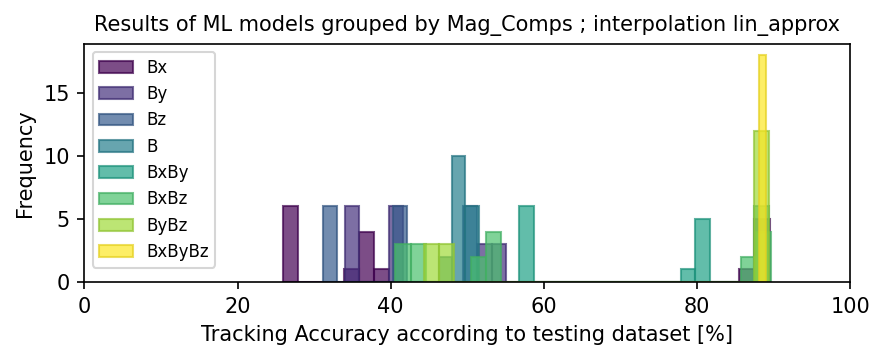

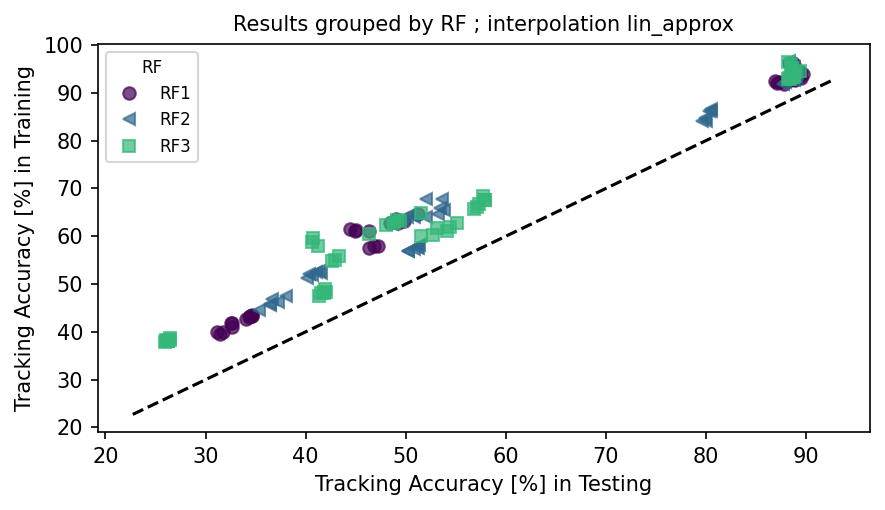

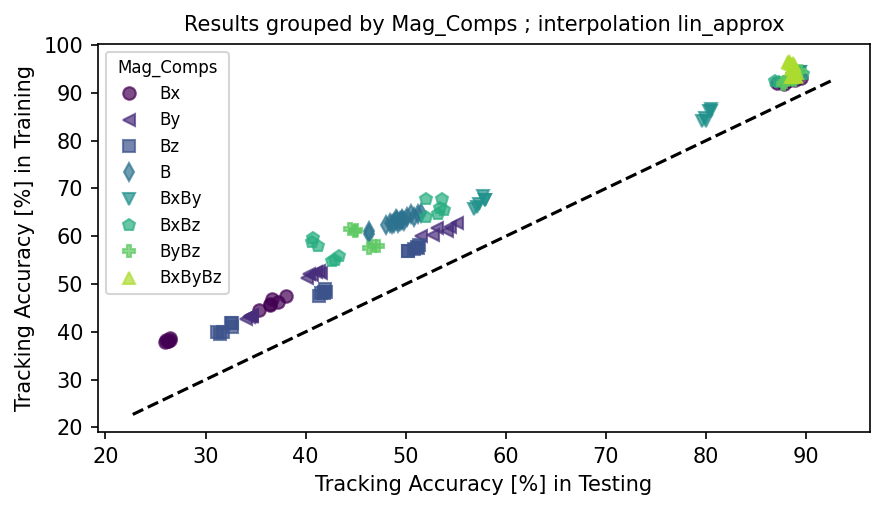

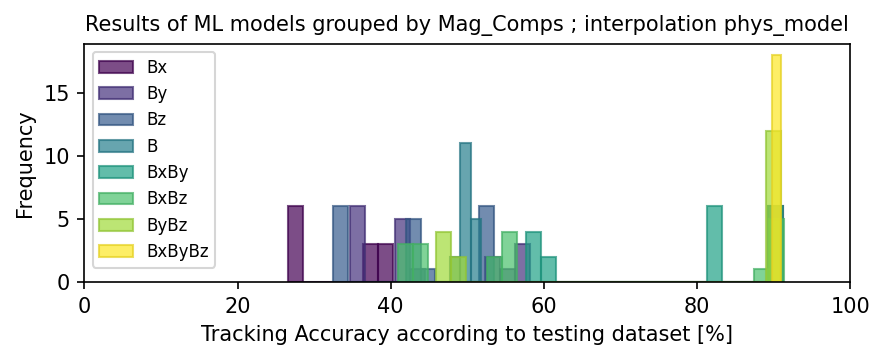

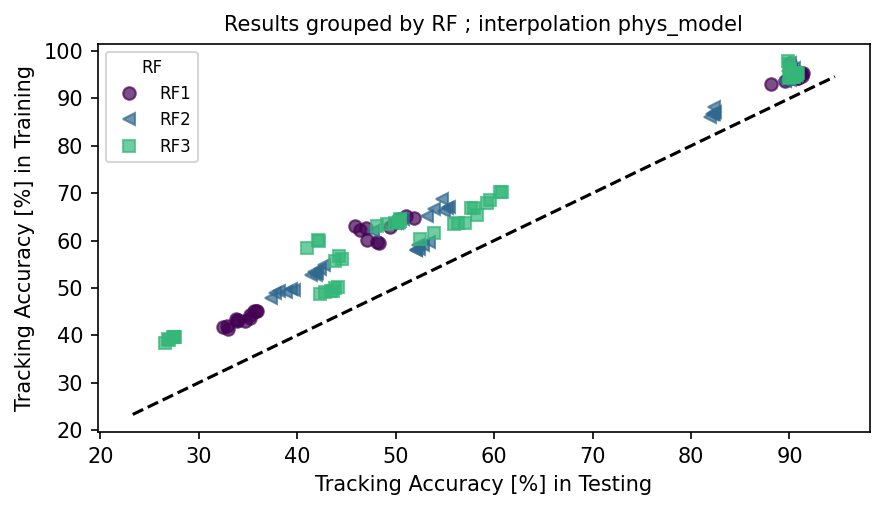

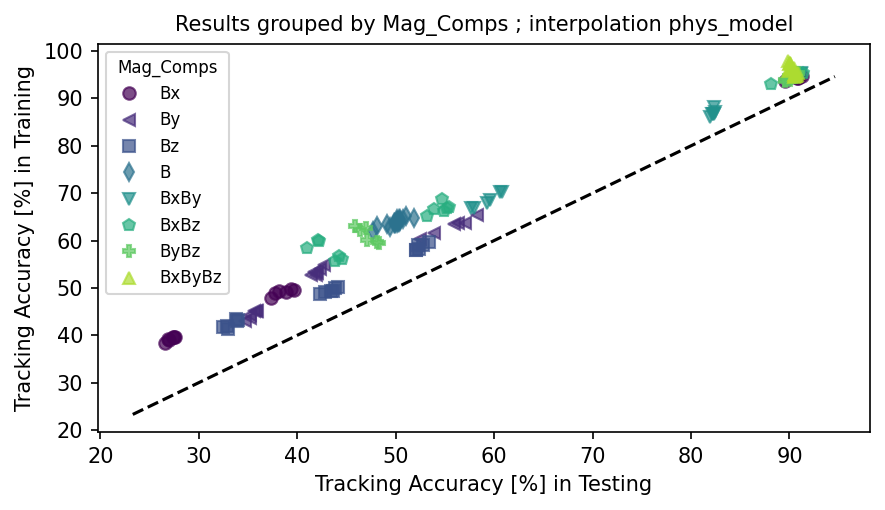

In [2]:
# Define the grouping variable and set the evaluation metrics:
group_var = 'Mag_Comps' # Grouping variable
test_col = 'Acc_Test_z' # Evaluation metric in testing dataset
train_col = 'Acc_Val_z' # Evaluation metric in validating dataset
gral_metric = 'Tracking Accuracy [%]' # General metric used in both training and testing datasets
xlabel_metric = 'Tracking Accuracy according to testing dataset [%]' # x-label in plot
stage = 'Stage1_' # Stage keyword

# Load data and see overall results:
res_S1 = {} # Initiate
for interp in interp_opts:
    if any([stage in file for file in gral_res_files[interp]]):       
        # Overall results:
        save_name = None # Choose saving name, if any
        res_S1[interp] = ML_analysis.load_results_and_overview(
            [file for file in gral_res_files[interp] if stage in file][0],
            group_var,interpolation=interp,
            eval_col=test_col,xlabel_metric=xlabel_metric,
            figsize=(6,2.5),save_name=save_name
        )
        # Training vs Testing results:
        save_name = None # Choose saving name, if any
        ML_analysis.plot_gen_test_vs_val(
            res_S1[interp],test_col=test_col,train_col=train_col,
            group_by=['RF',group_var],gral_metric=gral_metric,
            interpolation=interp,figsize=(6,3.5),save_name=save_name
        )

Only the group 'BxByBz' has a good and **constant** accuracy, while the other groups are spreaded. For example, group 'ByBz' has some very good accuracy values near 85%, but also very bad values near 30%.

Finally, let's plot the Tracking accuracy range (meaning a bar that comprises all results) for each option of magnetic components, taking into account all ML models and rotational frames.


Interpolation approach: lin_approx.
Best choice (based on lowest group-score): BxByBz
Lowest score for BxByBz: 88.2
Highest score for BxByBz: 89.7



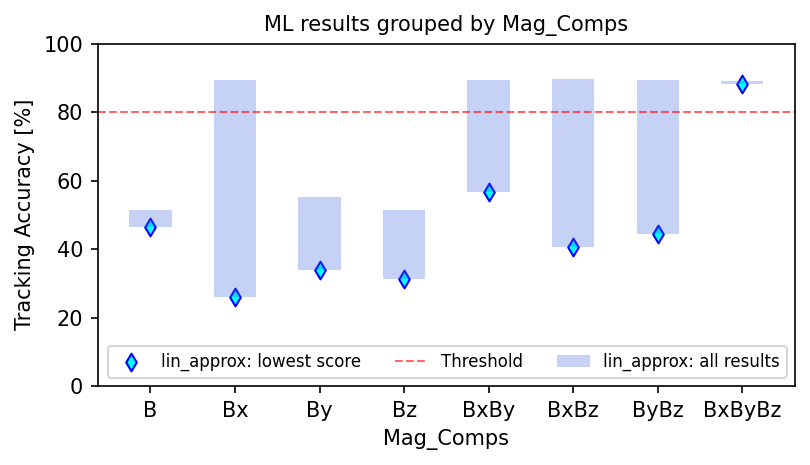

In [3]:
# Choose the approaches
approaches = ['lin_approx'] # 'lin_approx', 'phys_model'
res_S1_plot = {} # Auxiliar dictionary, only for plotting

# Define the grouping variable and additional configuration:
group_var = 'Mag_Comps' # Grouping variable
eval_col = 'Acc_Test_z' # Column to determine sorting order
i_order = {} # Initiate explicit order for variable options
for interp in approaches:
    res_S1_plot[interp] = res_S1[interp]
    i_order[interp] = ['B','Bx','By','Bz','BxBy','BxBz','ByBz','BxByBz'] # Explicit order for variable options
metric = 'Tracking Accuracy [%]' # Metrics used to evaluate the ML models
score_thres = 80 # Threshold for scoring (tracking accuracy [%])
y_lims = [0,100] # Plot limits (tracking accuracy [%])

# Plot the ML results according to the grouping configuration:
save_name = 'Images/Stage1_lin_approx' if 'phys_model' not in approaches else 'Images/Stage1_lin_approx_phys_model'
ML_analysis.group_results(
    res_S1_plot,group_var,eval_col=eval_col,i_order=i_order,
    metric=metric,score_thres=score_thres,y_lims=y_lims,
    save_name=save_name,save_format='svg',figsize=(5.5,3.2)    
    )

Comments: in both interpolation approaches, results are roughly similar, although the physical model interpolation works better.

**DECISION: Choose the full 3-channels data 'BxByBz' for the next training Stages.**

## Stage 2: Time window's length

This stage focuses on the **number of points for each Time Window**. Let's see the overall results, and the testing vs training evaluation comparison:

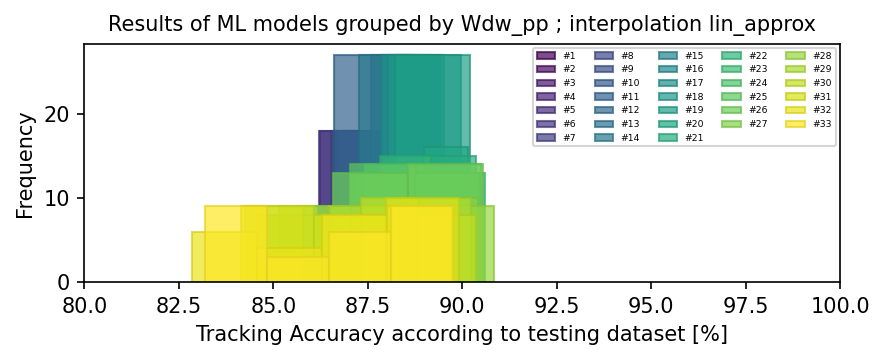

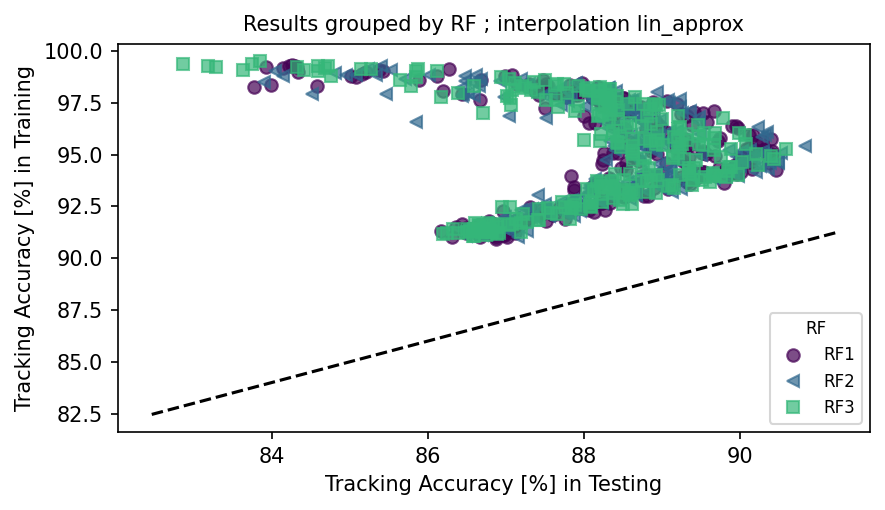

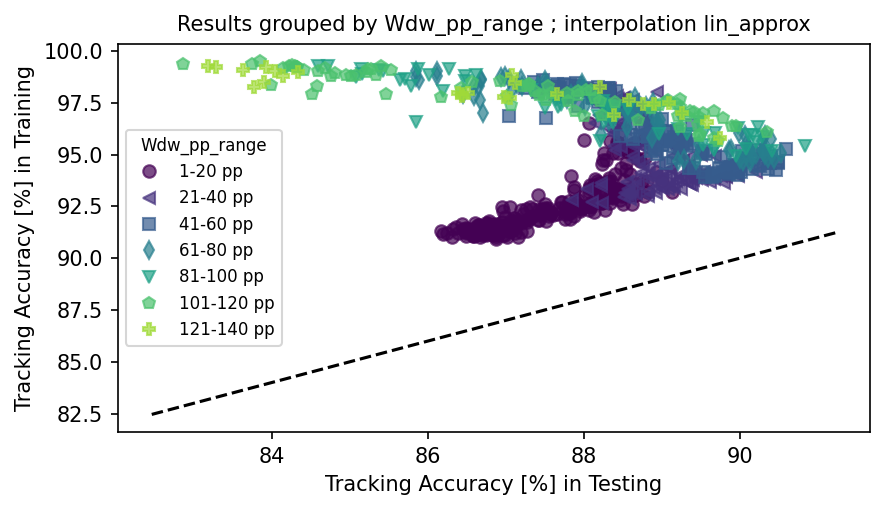

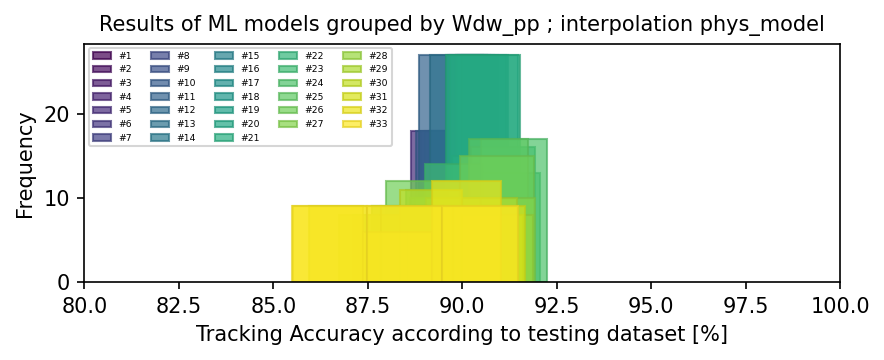

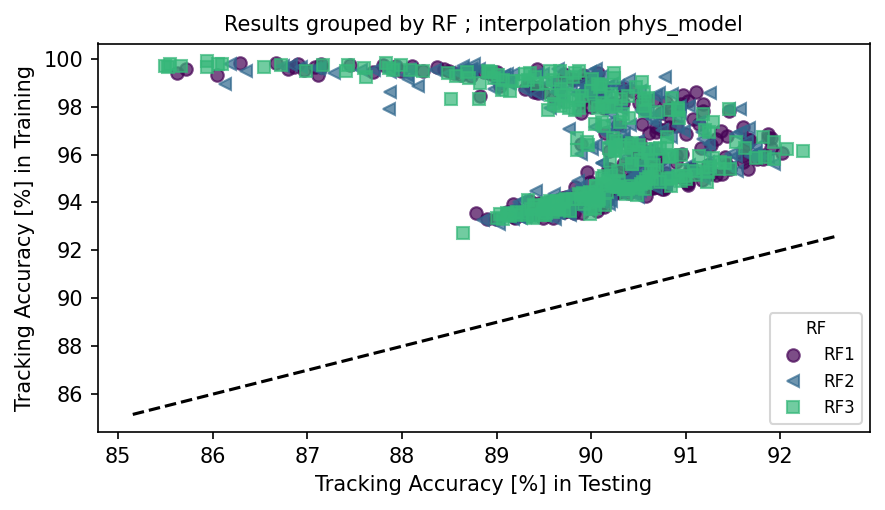

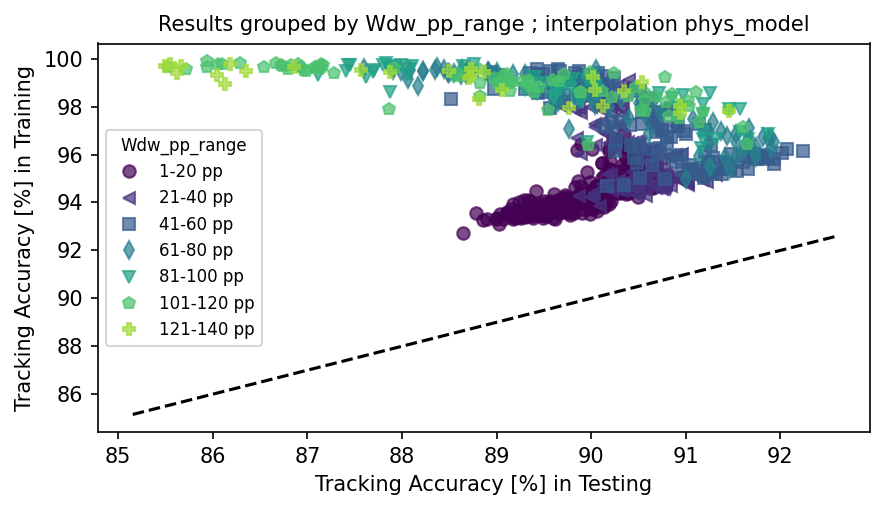

In [4]:
# Choose a ranging value for grouping time window's number of points, so it's easier to visualize: 
range_pp = 20
# Define the grouping variable and set the evaluation metrics:
group_var = 'Wdw_pp' # Grouping variable, to be defined later
group_var_range = 'Wdw_pp_range' # Ranged grouping variable, to be defined later
test_col = 'Acc_Test_z' # Evaluation metric in testing dataset
train_col = 'Acc_Val_z' # Evaluation metric in validating dataset
gral_metric = 'Tracking Accuracy [%]' # General metric used in both training and testing datasets
xlabel_metric = 'Tracking Accuracy according to testing dataset [%]' # x-label in plot
stage = 'Stage2_' # Stage keyword

# Load data and see overall results:
res_S2 = {} # Initiate
for interp in interp_opts:
    if any([stage in file for file in gral_res_files[interp]]):        
        # Overall results:
        save_name = None # Choose saving name, if any
        res_S2[interp] = ML_analysis.load_results_and_overview(
            [file for file in gral_res_files[interp] if stage in file][0],
            group_var,interpolation=interp,
            eval_col=test_col,xlabel_metric=xlabel_metric,
            x_lims=[80,100],figsize=(6,2.5),save_name=save_name
        )
        # Group number of time window points by ranges:
        res_S2[interp][group_var_range] = res_S2[interp][group_var].apply(
            lambda x: f'{x//range_pp * range_pp+1}-{(x+range_pp)//range_pp * range_pp} pp'
        )
        # Training vs Testing results:
        save_name = None # Choose saving name, if any
        ML_analysis.plot_gen_test_vs_val(
            res_S2[interp],test_col=test_col,train_col=train_col,
            group_by=['RF',group_var_range],gral_metric=gral_metric,
            interpolation=interp,figsize=(6,3.5),save_name=save_name
        )

Conclusion:
* There is a quality jump when time windows go beyond 10 points, achieving better results in most cases. With more than 40 points, performances are similar and more points is not necessarily better, specially taking into account that longer windows imply heavier ML models.

### Results grouped by time windows' length

Now, let's take the best result for each time windows' length and each RF frame, among all possible ML architectures.

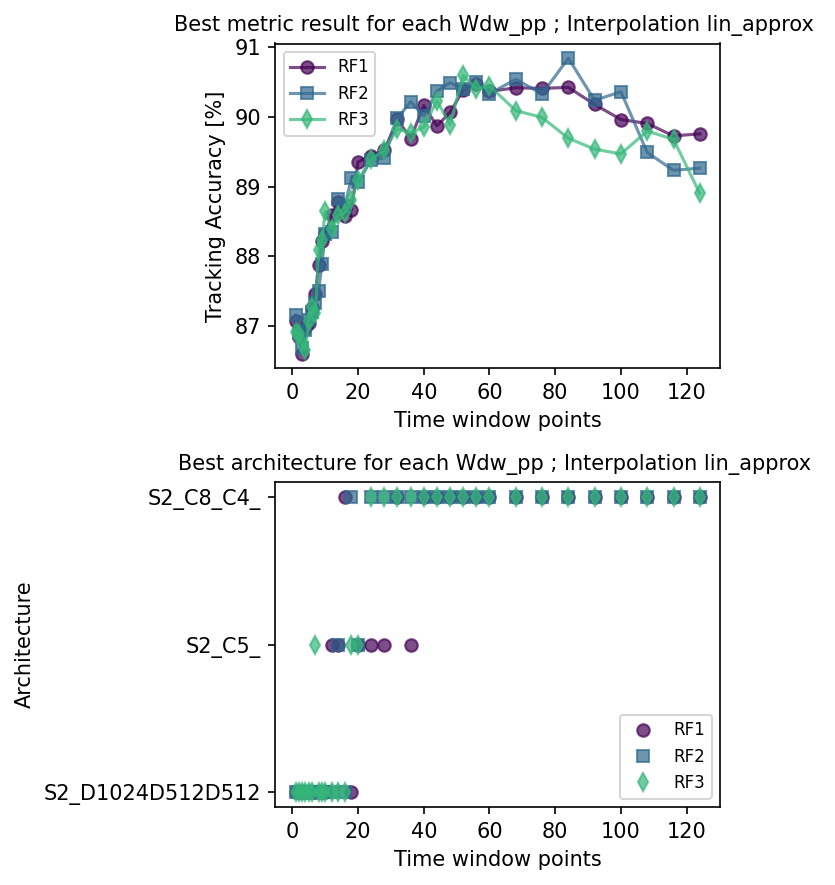

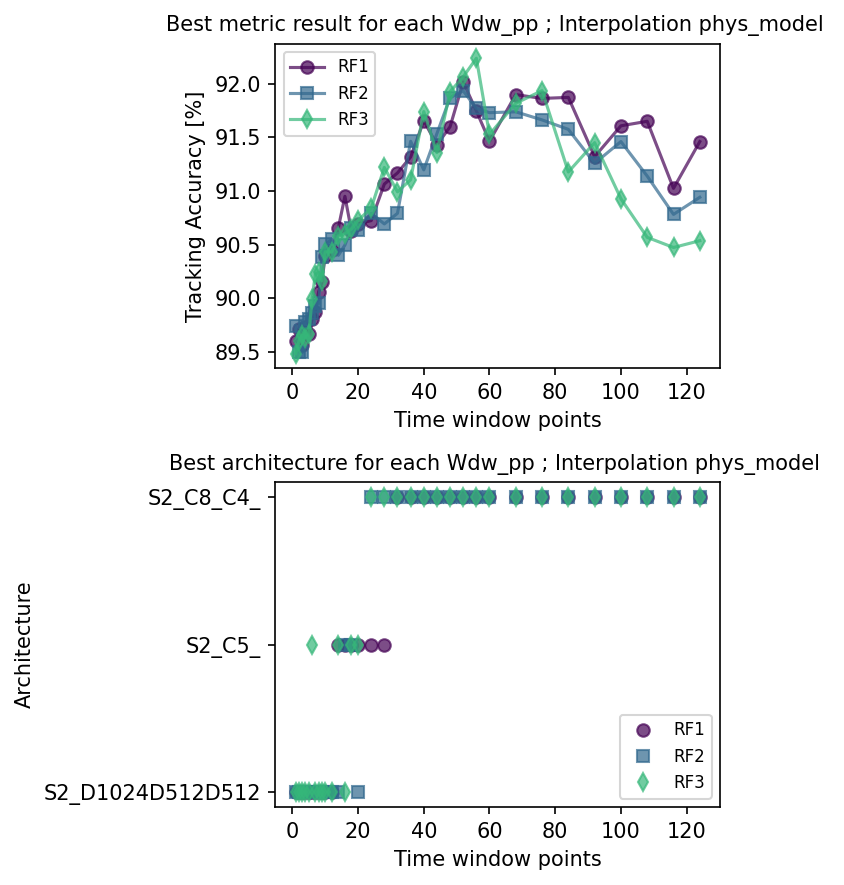

In [5]:
# Set grouping variable and general parameteres:
group_var = 'Wdw_pp' # Grouping variable
eval_col = 'Acc_Test_z' # Evaluation metric
xlabel = 'Time window points'
metric = 'Tracking Accuracy [%]' # Evaluation metric, ylabel in the plot
# Plot results:
for interp in interp_opts:
    if interp in res_S2:
        save_name = None
        ML_analysis.plot_best_results_and_archs(
            res_S2[interp],group_var,xlabel=xlabel,eval_col=eval_col,
            metric=metric,interpolation=interp,save_name=save_name
        )

From this analysis, we can conclude there is an optimal number of time windows points, between 40 and 80, for which the ML models generally increase their performance.

On the other hand, we can conclude that architectures including Convolutional and Dense layers are superior to those having only Dense layers when the number of points starts to increase (from 20 points onwards in this case).

Finally, let's select the best architecture for each number of points within the time windows, and plot the Tracking accuracy range (meaning a bar that comprises all results) for each option of time window points, taking into account all rotational frames.


Interpolation approach: lin_approx.
Best choice (based on lowest group-score): 60
Lowest score for 60: 89.9
Highest score for 60: 90.8



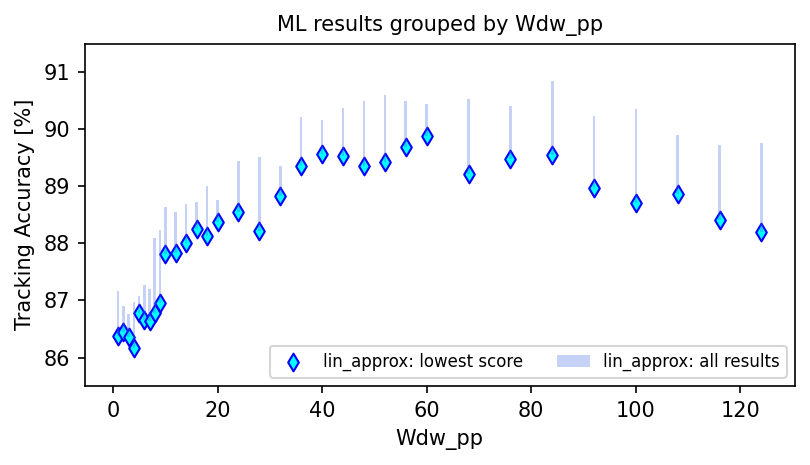

In [6]:
# Choose the approaches
approaches = ['lin_approx'] # 'lin_approx', 'phys_model'

# Set parameters to choose best architectures:
variable = 'Wdw_pp'
eval_col = 'Acc_Test_z' # Evaluation metric
# Choose best architectures:
res_S2_best_archs = {} # Initiate
for interp in approaches:
    if interp in res_S2:
        res_S2_best_archs[interp] = ML_analysis.keep_best_archs(
            res_S2[interp],variable,eval_col)

# Define the grouping variable and additional configuration:
group_var = 'Wdw_pp' # Grouping variable
eval_col = 'Acc_Test_z' # Column to determine sorting order
metric = 'Tracking Accuracy [%]' # Metrics used to evaluate the ML models
y_lims = [85.5,91.5] if 'phys_model' not in approaches else [83,93] # Plot limits (tracking accuracy [%])

# Plot the ML results according to the grouping configuration:
save_name = 'Images/Stage2_lin_approx' if 'phys_model' not in approaches else 'Images/Stage2_lin_approx_phys_model'
ML_analysis.group_results(
    res_S2_best_archs,group_var,eval_col=eval_col,metric=metric,
    y_lims=y_lims,save_name=save_name,save_format='svg',figsize=(5.5,3.2)    
    )

Comments: in both interpolation approaches, results are roughly similar, although the physical model interpolation works better.

Having too few or too many points for the time windows lead to underperforming models. Within the higher-performance range, we choose the lowest possible number of points, so the ML is lighter. 

**DECISION: Choose the 40-points (4s) time windows for the next training Stages.**

## Stage 3

This stage focuses on choosing the optimal **main ML model's architecture**, meaning the Convolutional, Flattening and Dense layers. Let's see the overall results:

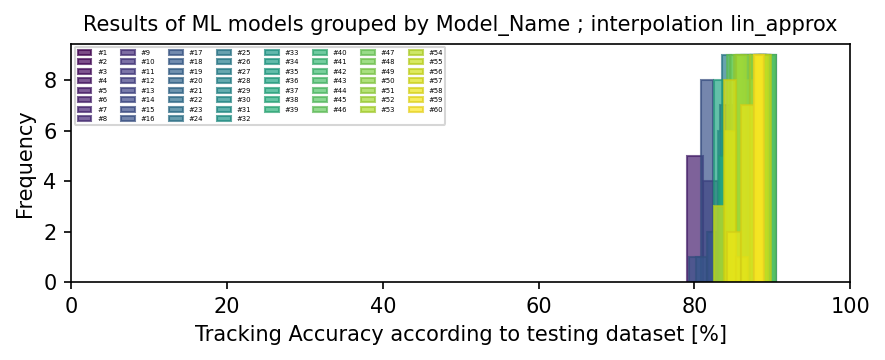

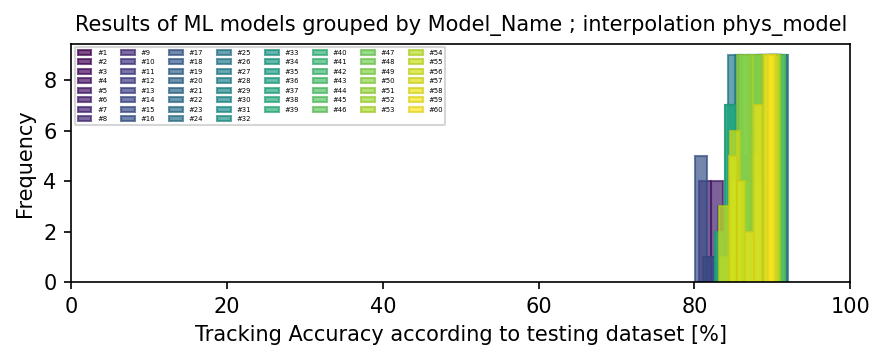

In [7]:
# Define the grouping variable and set the evaluation metrics:
group_var = 'Model_Name' # Grouping variable
test_col = 'Acc_Test_z' # Evaluation metric in testing dataset
train_col = 'Acc_Val_z' # Evaluation metric in validating dataset
gral_metric = 'Tracking Accuracy [%]' # General metric used in both training and testing datasets
xlabel_metric = 'Tracking Accuracy according to testing dataset [%]' # x-label in plot
stage = 'Stage3_' # Stage keyword

# Load data and see overall results:
res_S3 = {} # Initiate
for interp in interp_opts:
    if any([stage in file for file in gral_res_files[interp]]):       
        # Overall results:
        save_name = None # Choose saving name, if any
        res_S3[interp] = ML_analysis.load_results_and_overview(
            [file for file in gral_res_files[interp] if stage in file][0],
            group_var,interpolation=interp,
            eval_col=test_col,xlabel_metric=xlabel_metric,
            figsize=(6,2.5),save_name=save_name
        )

There are many unique architectures, and they include several parameters, so let's separate the information into pieces:

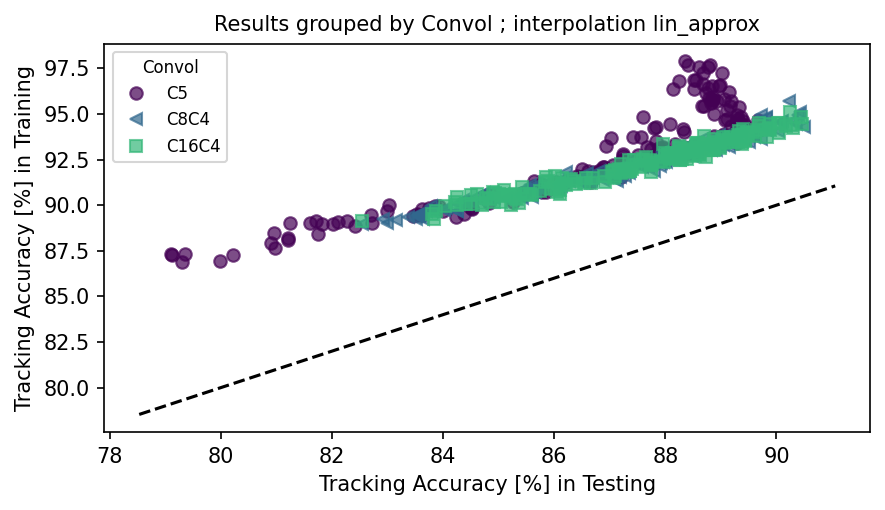

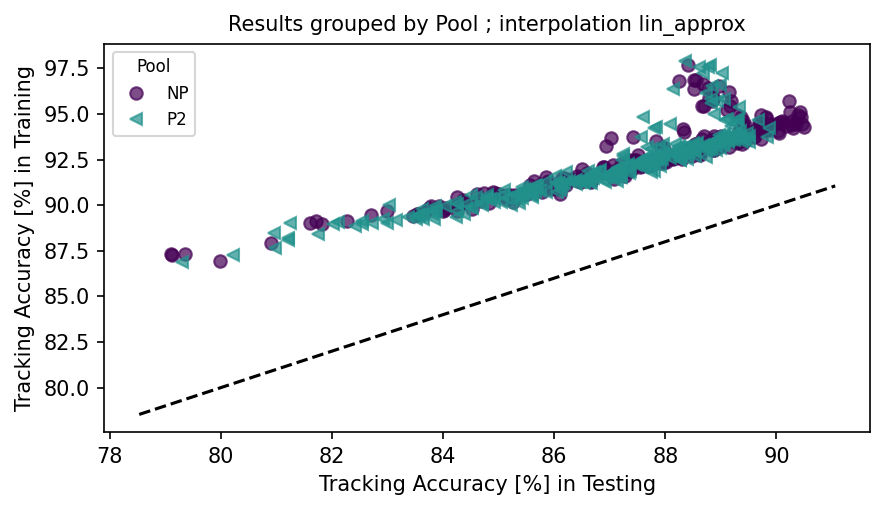

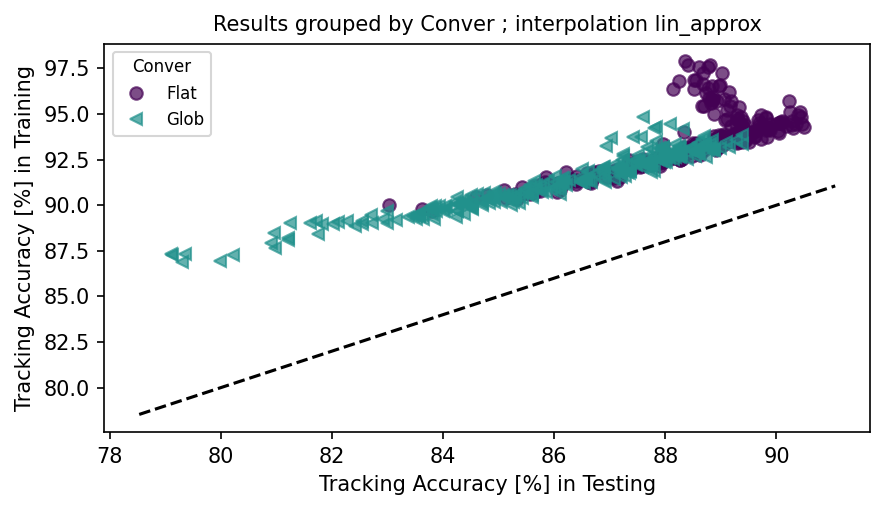

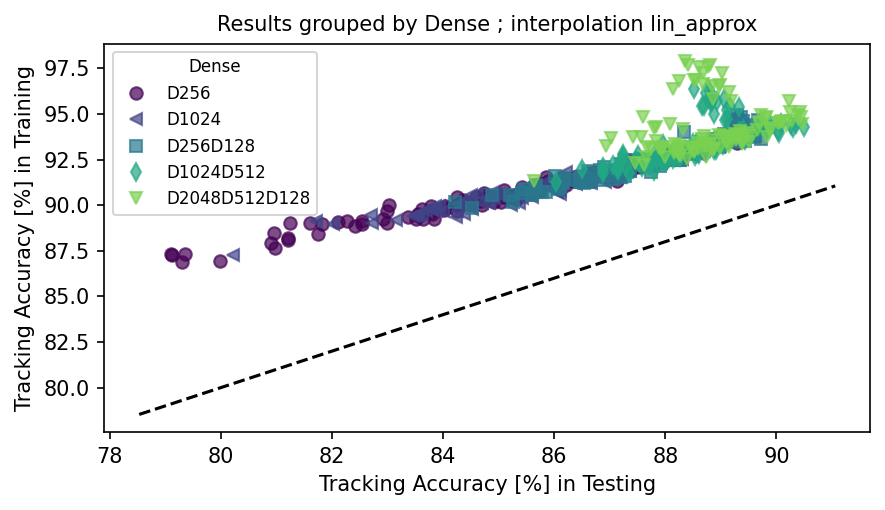

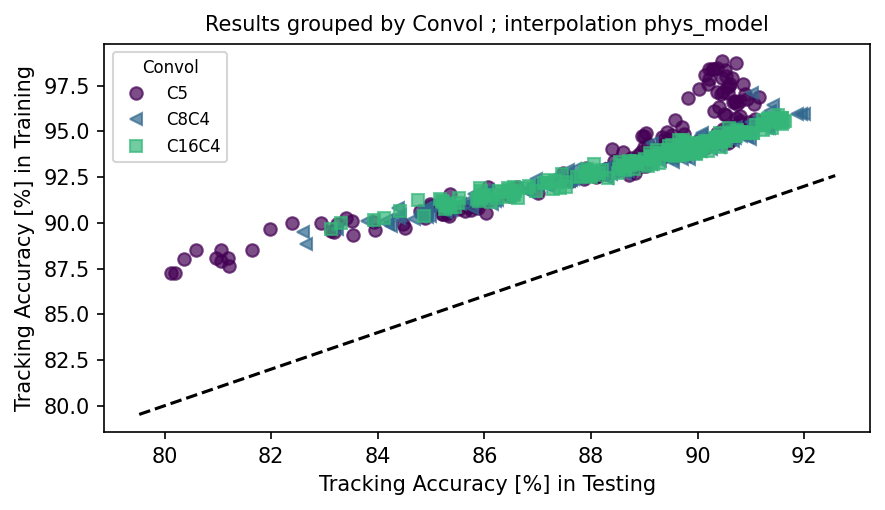

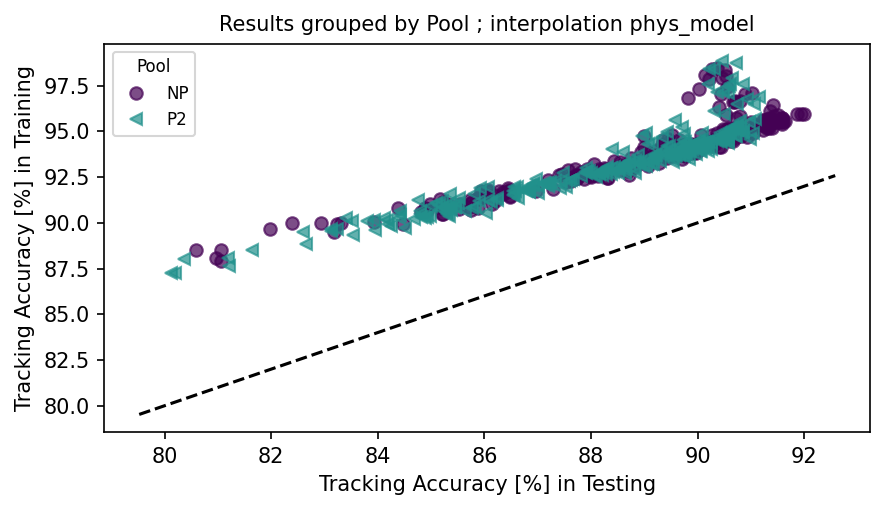

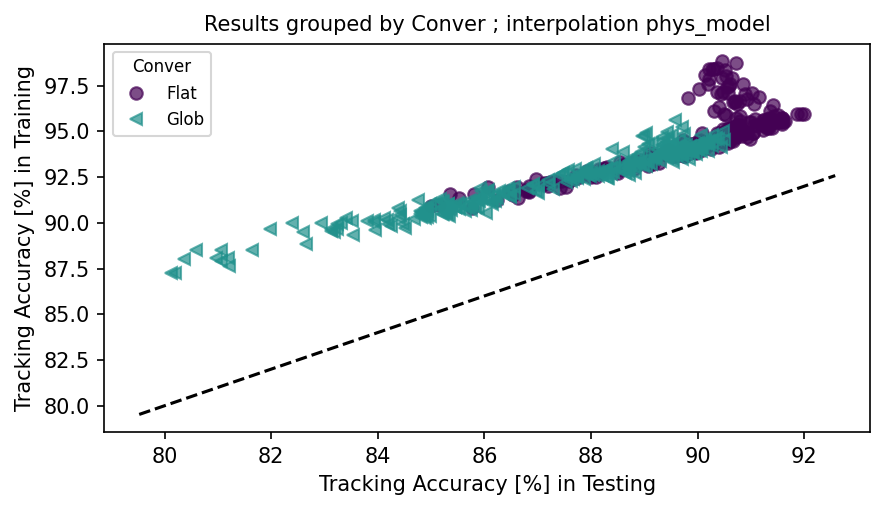

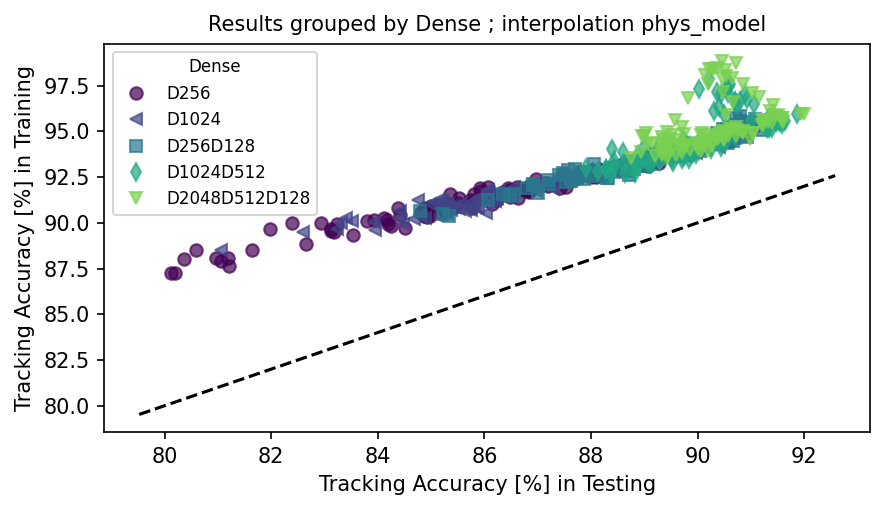

In [8]:
for interp in interp_opts:
    if interp in res_S3:
        # Add architecture columns to the dataframe:
        res_S3[interp]['Convol'] = res_S3[interp]['Model_Name'].apply(
            lambda x: ''.join([l for l in x.split('_') if 'C' in l]))
        res_S3[interp]['Pool'] = res_S3[interp]['Model_Name'].apply(
            lambda x: ''.join([l for l in x.split('_') if 'P' in l]))
        res_S3[interp]['Conver'] = res_S3[interp]['Model_Name'].apply(
            lambda x: 'Flat' if 'Flat' in x else 'Glob')
        res_S3[interp]['Dense'] = res_S3[interp]['Model_Name'].apply(
            lambda x: ''.join([l for l in x.split('_') if 'D' in l]))
        # Plot training vs testing results:
        save_name = None # Choose saving name, if any
        ML_analysis.plot_gen_test_vs_val(
            res_S3[interp],test_col=test_col,train_col=train_col,
            group_by=["Convol","Pool","Conver","Dense"],
            gral_metric=gral_metric,interpolation=interp,
            figsize=(6,3.5),save_name=save_name
        )

Some remarks:

* Convolutional layers: having two layers is better than one. Maybe C16C4 is more efficient than C8C4.

* Pooling layers: Non-pooling works better.

* 1D-Conversion layer: Flattening is better than Global.

* Dense layers: Higher complexity works better, either D1024D512 or D2048D512D128.

In the next step, I will only analyze all possible combinations among [C16C4, C8C4] + [Flattening] + [D1024D512, D2048D512D128]


In [9]:
# Architecture fine selection:
res_S3_selec = {} # Initiate
for interp in interp_opts:
    if interp in res_S3:
        # Conditions (select rows within dataset):
        Convol_cond = ((res_S3[interp]['Convol']=='C16C4') |
                       (res_S3[interp]['Convol']=='C8C4'))
        Pool_cond = (res_S3[interp]['Pool']=='NP')
        Conver_cond = (res_S3[interp]['Conver']=='Flat')
        Dense_cond = ((res_S3[interp]['Dense']=='D1024D512') |
                      (res_S3[interp]['Dense']=='D2048D512D128'))
        # Make a new dataset with only selected architectures:
        res_S3_selec[interp] = res_S3[interp][(Convol_cond & Pool_cond & Conver_cond & Dense_cond)]
        res_S3_selec[interp]['Architecture'] = (res_S3_selec[interp]['Convol'] +
                                                res_S3_selec[interp]['Pool'] +
                                                res_S3_selec[interp]['Conver'] +
                                                res_S3_selec[interp]['Dense'])

Finally, let's plot the Tracking accuracy range (meaning a bar that comprises all results) for each architecture option (fine selection), taking into account all rotational frames.


Interpolation approach: lin_approx.
Best choice (based on lowest group-score): C8C4NPFlatD2048D512D128
Lowest score for C8C4NPFlatD2048D512D128: 89.7
Highest score for C8C4NPFlatD2048D512D128: 90.5


Interpolation approach: phys_model.
Best choice (based on lowest group-score): C16C4NPFlatD2048D512D128
Lowest score for C16C4NPFlatD2048D512D128: 91.0
Highest score for C16C4NPFlatD2048D512D128: 92.0



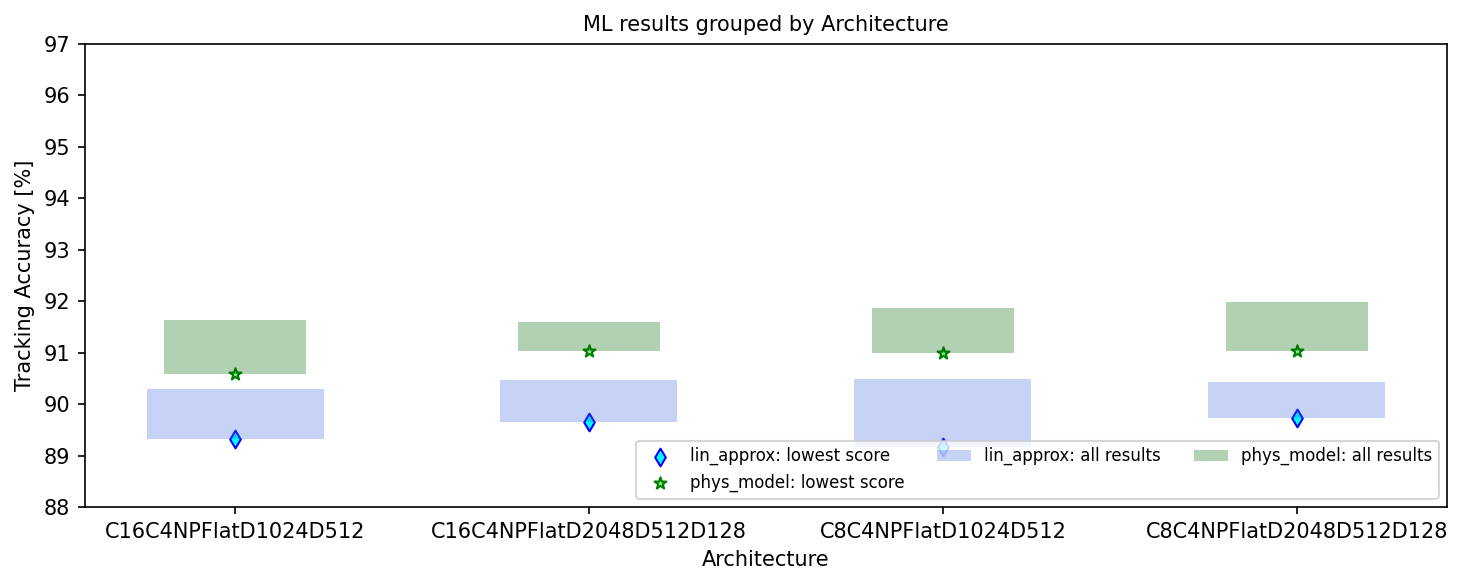

In [10]:
# Define the grouping variable and additional configuration:
group_var = 'Architecture' # Grouping variable
eval_col = 'Acc_Test_z' # Column to determine sorting order
metric = 'Tracking Accuracy [%]' # Metrics used to evaluate the ML models
y_lims = [88,97] # Plot limits (tracking accuracy [%])

# Plot the ML results according to the grouping configuration:
save_name = None
ML_analysis.group_results(
    res_S3_selec,group_var,eval_col=eval_col,metric=metric,
    y_lims=y_lims,save_name=save_name,save_format='png',figsize=(10,4)    
    )

**DECISION: Choose the following architecture:**

* Convolutional layers (filter,kernel): [32,8] + [32,4]
* Pooling layers: None
* 1D-Conversion layer: Flattening
* Dense layers: [1024] + [512]

## Stage 4: Global hyperparameters

This stage focuses on selecting the optimal **ML model's global hyperparameters**, meaning the optimizer, activation functions and learning rate. Let's see the overall results, and the testing vs training evaluation comparison:

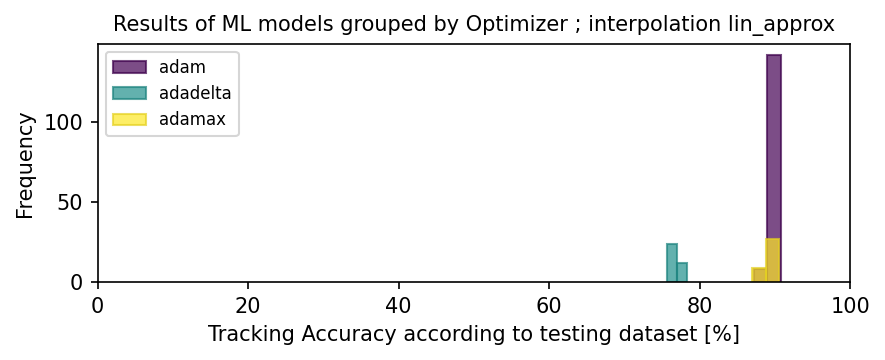

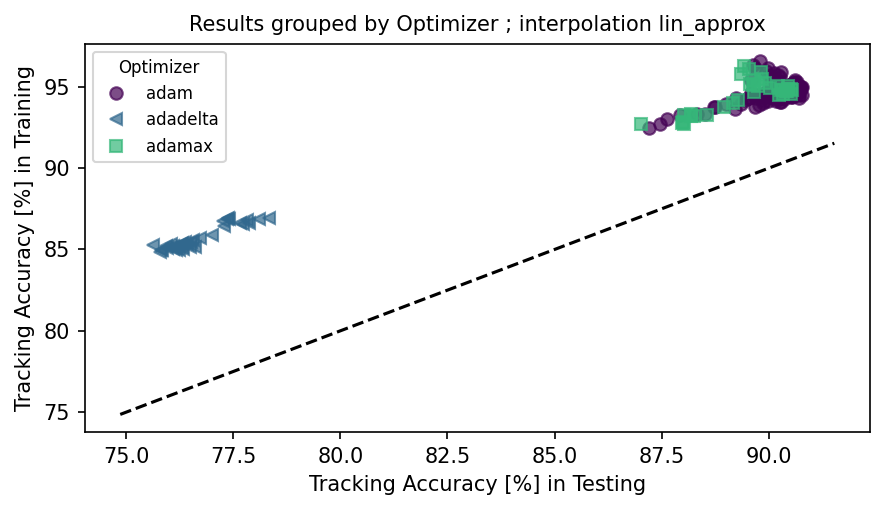

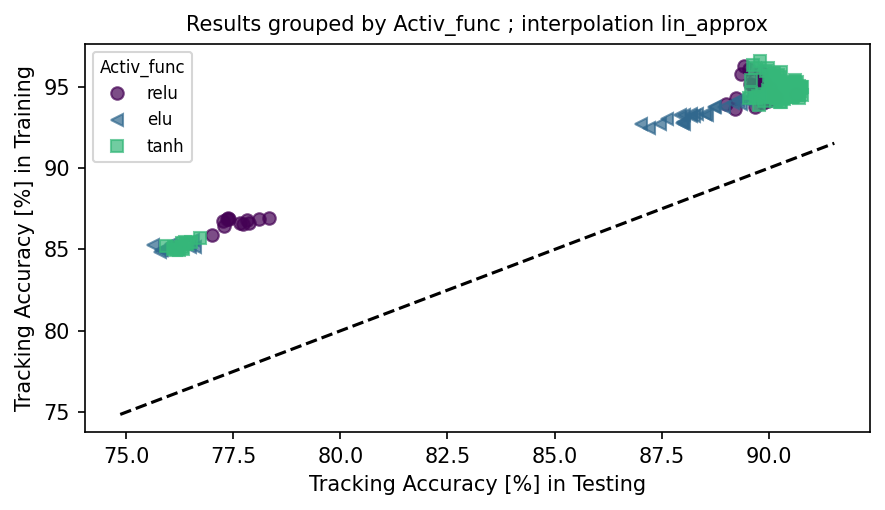

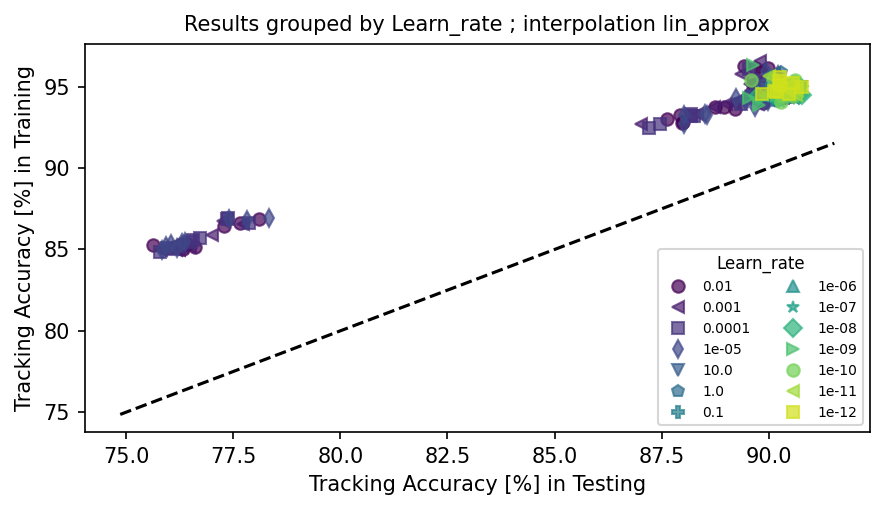

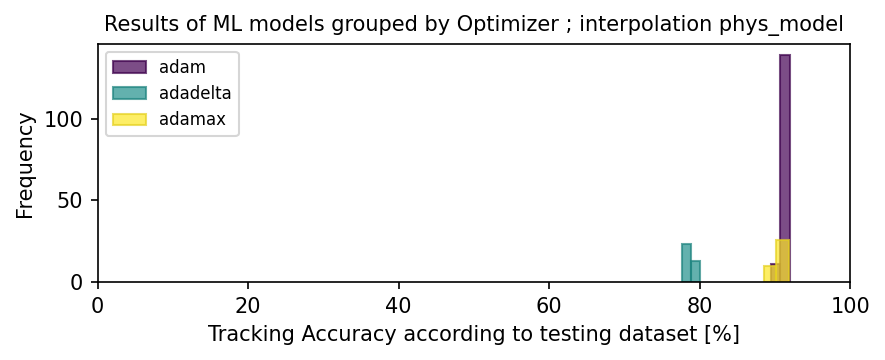

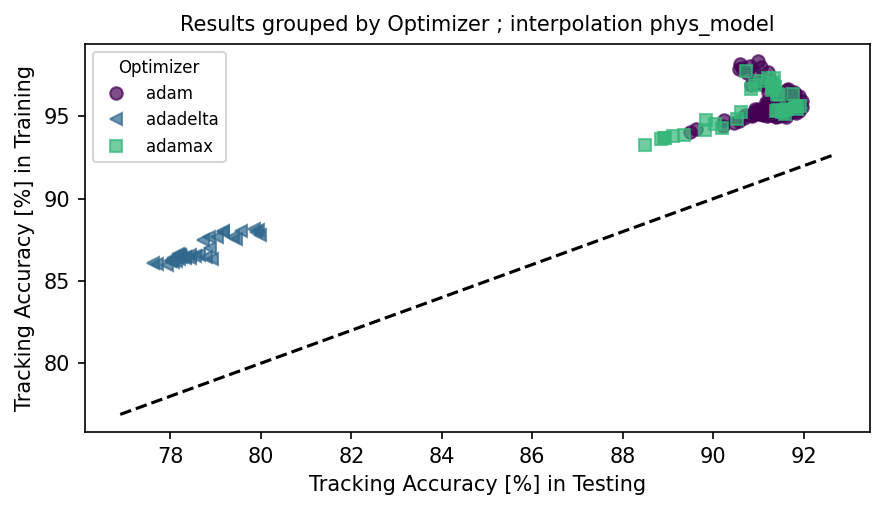

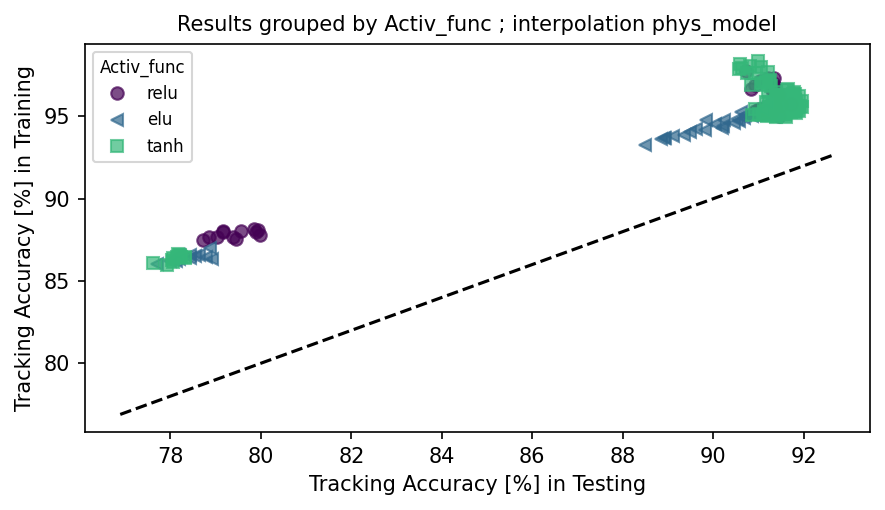

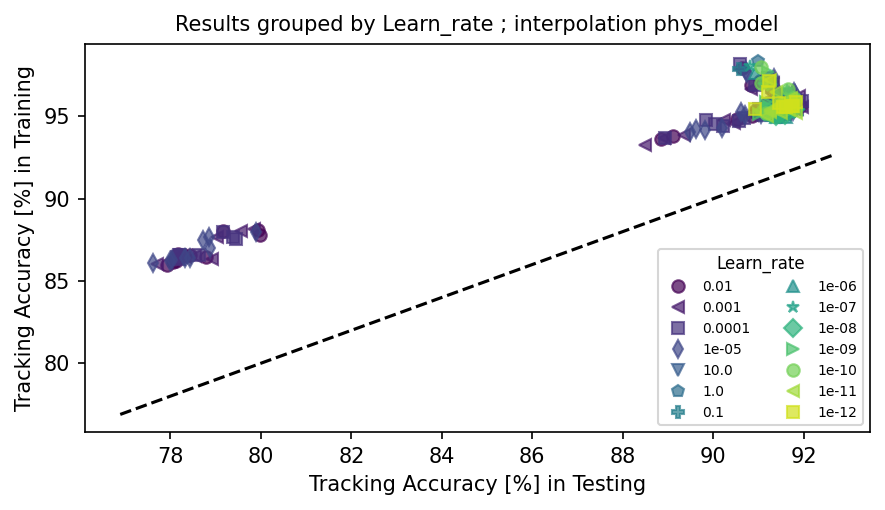

In [11]:
# Define the grouping variable and set the evaluation metrics:
group_var = 'Optimizer' # Grouping variable
test_col = 'Acc_Test_z' # Evaluation metric in testing dataset
train_col = 'Acc_Val_z' # Evaluation metric in validating dataset
gral_metric = 'Tracking Accuracy [%]' # General metric used in both training and testing datasets
xlabel_metric = 'Tracking Accuracy according to testing dataset [%]' # x-label in plot
stage = 'Stage4_' # Stage keyword

# Load data and see overall results:
res_S4 = {} # Initiate
for interp in interp_opts:
    if any([stage in file for file in gral_res_files[interp]]):       
        # Overall results:
        save_name = None # Choose saving name, if any
        res_S4[interp] = ML_analysis.load_results_and_overview(
            [file for file in gral_res_files[interp] if stage in file][0],
            group_var,interpolation=interp,
            eval_col=test_col,xlabel_metric=xlabel_metric,
            figsize=(6,2.5),save_name=save_name
        )
        # Training vs Testing results:
        save_name = None # Choose saving name, if any
        ML_analysis.plot_gen_test_vs_val(
            res_S4[interp],test_col=test_col,train_col=train_col,
            group_by=['Optimizer','Activ_func','Learn_rate'],gral_metric=gral_metric,
            interpolation=interp,figsize=(6,3.5),save_name=save_name
        )

Conclusions:
* Optimizers: **adadelta** does not work well, while **adam** and **adamax** have similar results.
* Activation function: **tanh** seems to work best, followed by **relu** and then **elu**
* Learning rate: Hard to tell from these plots...

Based on these observations, I make a fine selection of the global parameters, make a reduced dataset with the best ML models and repeat the analysis. These are the accepted options:
* Optimizer: **adam** or **adamax**.
* Activation function: **tanh** or **relu**.

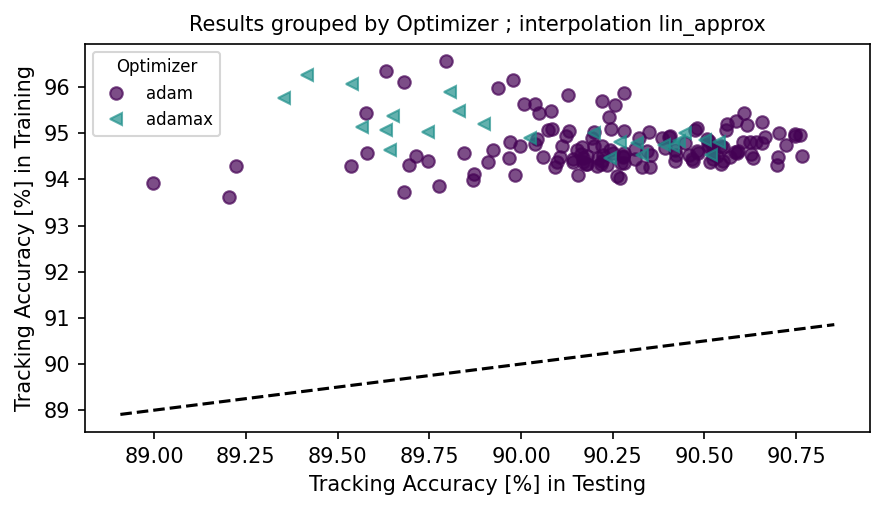

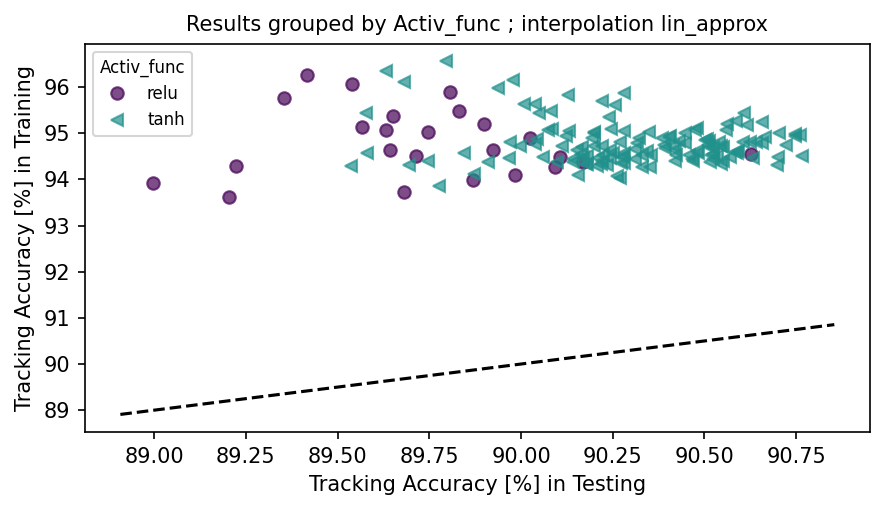

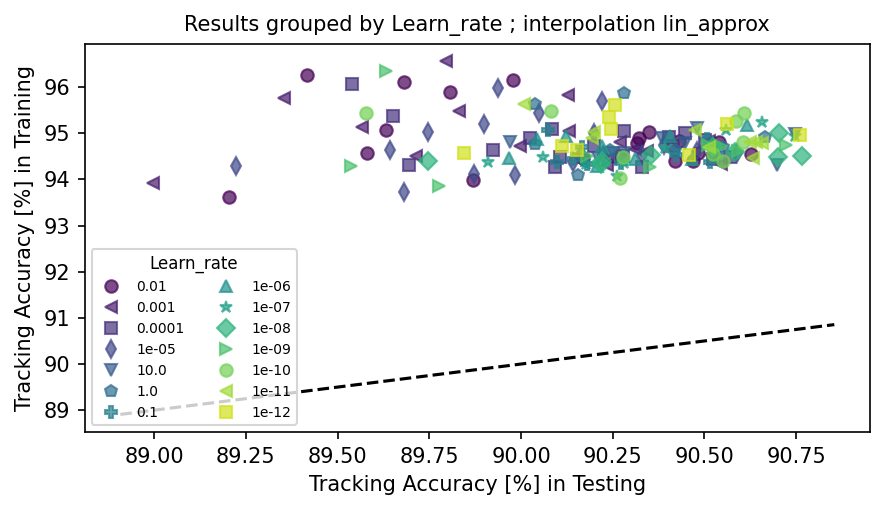

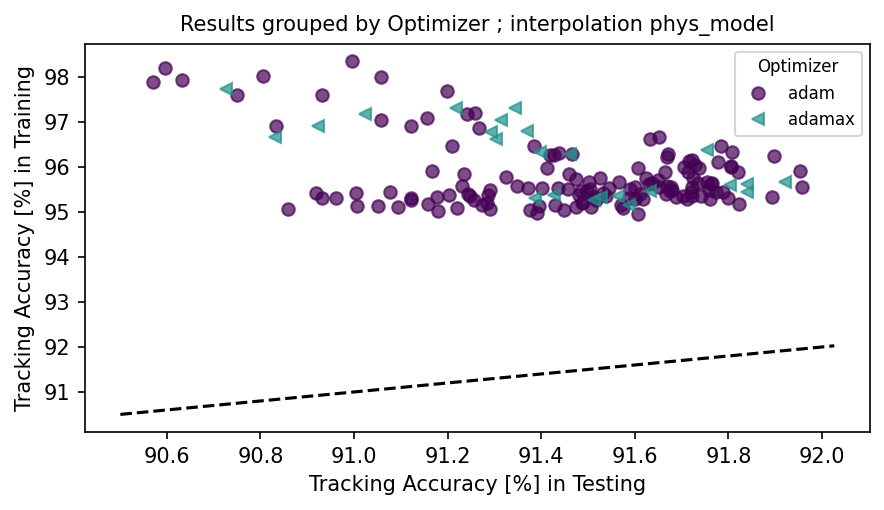

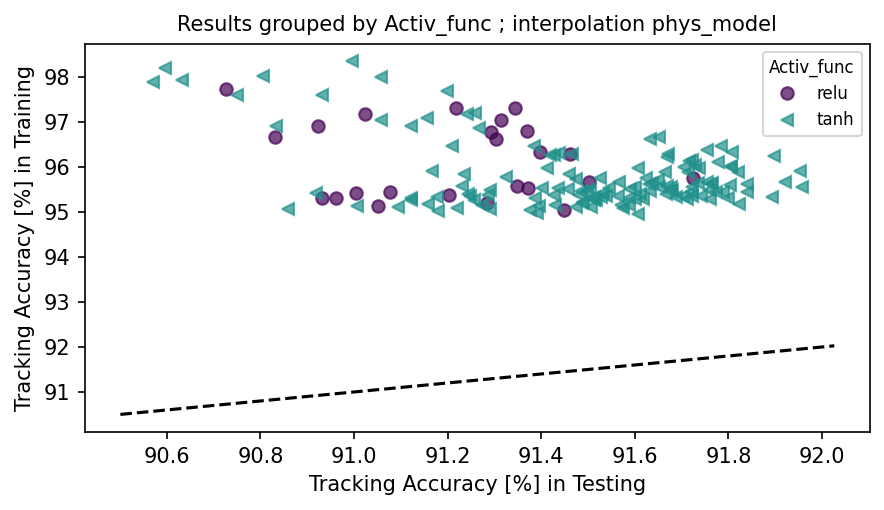

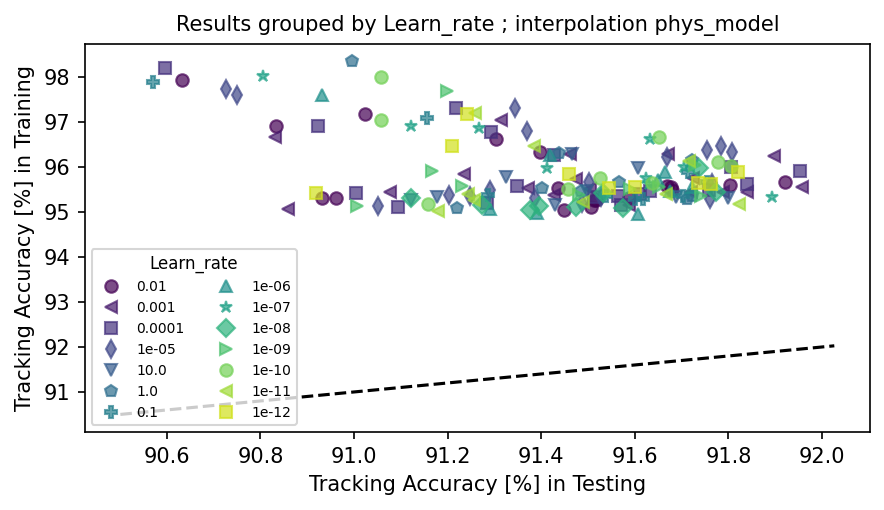

In [12]:
# Global hyperparameters fine selection:
res_S4_selec = {} # Initiate
for interp in interp_opts:
    if interp in res_S4:
        # Conditions (select rows within dataset):
        cond_opt = (res_S4[interp]['Optimizer'] != 'adadelta')
        cond_activ = (res_S4[interp]['Activ_func'] != 'elu')
        # Make a new dataset with only selected architectures:
        res_S4_selec[interp] = res_S4[interp][(cond_opt & cond_activ)].reset_index()
        
        # Training vs Testing results:
        save_name = None # Choose saving name, if any
        ML_analysis.plot_gen_test_vs_val(
            res_S4_selec[interp],test_col=test_col,train_col=train_col,
            group_by=['Optimizer','Activ_func','Learn_rate'],gral_metric=gral_metric,
            interpolation=interp,figsize=(6,3.5),save_name=save_name
        )

By looking at these plots, conclusions for activation functions are clear: 'tanh' is better. Regarding the optimizers, 'adam' and 'adamax' have similar performance, with a bit advantage for 'adam', which we keep. For learning rates, it's hard to tell if there is any better rate, so we will make a choice later:

- Keep **adam** as optimizer.
- Keep **tanh** as activation function.
- Learning rate to be determined.

As the last analysis, we make a new selection based on these options and plot the Tracking accuracy range (meaning a bar that comprises all results) for each learning rate option (fine selection), taking into account all rotational frames.


Interpolation approach: lin_approx.
Best choice (based on lowest group-score): 1e-01
Lowest score for 1e-01: 90.1
Highest score for 1e-01: 90.8


Interpolation approach: phys_model.
Best choice (based on lowest group-score): 1e-11
Lowest score for 1e-11: 91.2
Highest score for 1e-11: 92.0



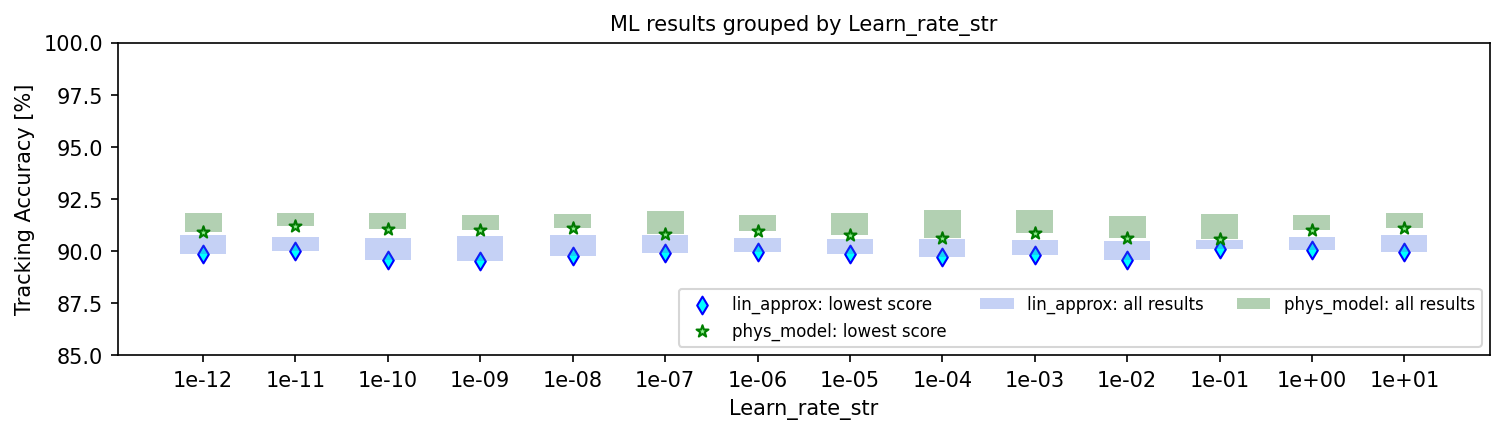

In [13]:
# Define the ML evaluation configuration, grouping variable will be defined later:
eval_col = 'Acc_Test_z' # Column to determine sorting order
metric = 'Tracking Accuracy [%]' # Metrics used to evaluate the ML models
y_lims = [85,100] # Plot limits (tracking accuracy [%])        
group_var = 'Learn_rate_str' # Grouping variable (it will be created later)

# Global hyperparameters fine selection:
res_S4_selec_2, i_order = {}, {} # Initiate
for interp in interp_opts:
    if interp in res_S4_selec:
        # Conditions (select rows within dataset):
        cond_opt = (res_S4_selec[interp]['Optimizer'] == 'adam')
        cond_activ = (res_S4_selec[interp]['Activ_func'] == 'tanh')
        # Make a new dataset with only selected architectures:
        res_S4_selec_2[interp] = res_S4_selec[interp][(
            cond_opt & cond_activ)].reset_index()

        # Convert learning rate variables into strings, necessary for next plot:
        res_S4_selec_2[interp]['Learn_rate_str'] = res_S4_selec_2[interp]['Learn_rate'].apply(
            lambda x: '{:.0e}'.format(x))
        
        # Sort the learning rate values:
        i_order[interp] = ['{:.0e}'.format(x) for x in sorted(set(res_S4_selec_2[interp]['Learn_rate']))]
        
# Plot tracking accuracy:
save_name = None
ML_analysis.group_results(
    res_S4_selec_2,group_var,eval_col=eval_col,i_order=i_order,
    metric=metric,y_lims=y_lims,save_name=save_name,save_format='png',
    figsize=(10,3)    
    )       

There's no much different for ML results based on the different learning rates. We choose 1e-4, which performs slightly better and with little variation from model to model.

**DECISION for parameters to carry on to next stages:**

Optimizer: **adam**.

Activation function: **tanh**.

Learning rate: **1e-4**.

## Stage 5: Fine architecture

This stage focuses on the **fine architecture** for the ML models, meaning the number of filters in the Convolutional layers and the Dropout fraction in the Dense layers. Let's see the overall results, and the testing vs training evaluation comparison:

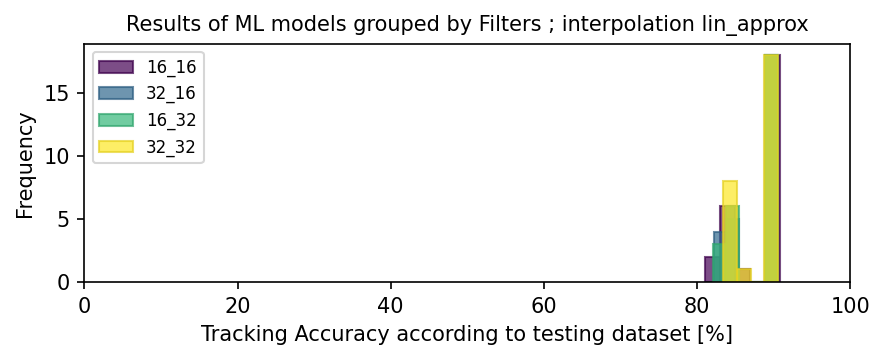

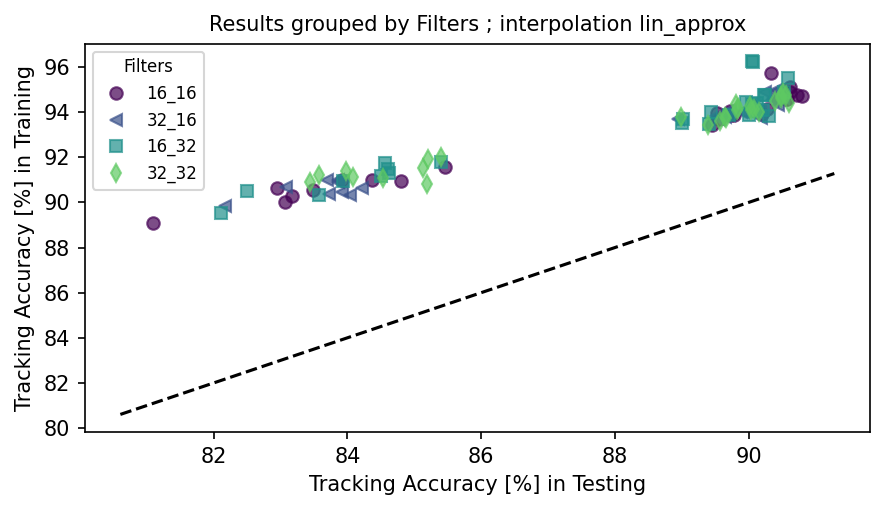

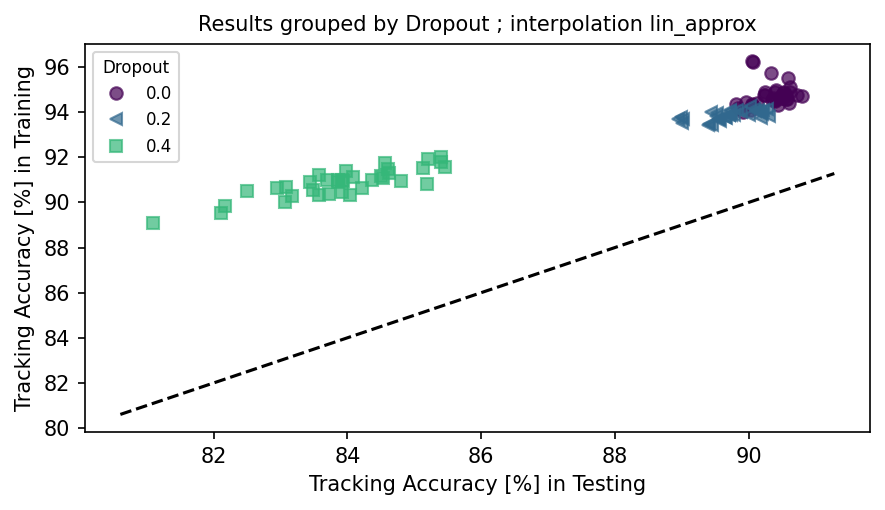

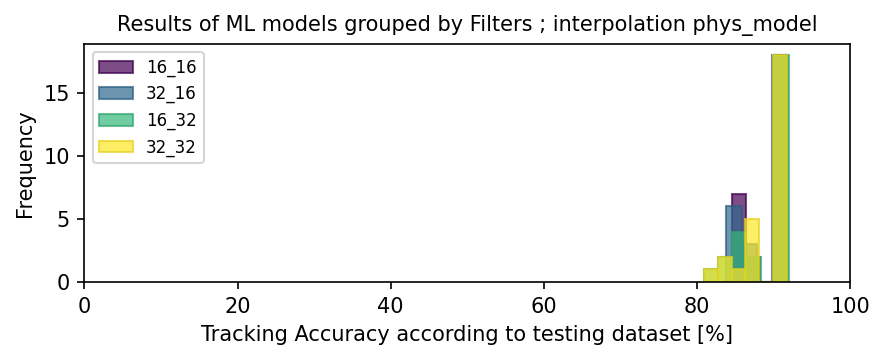

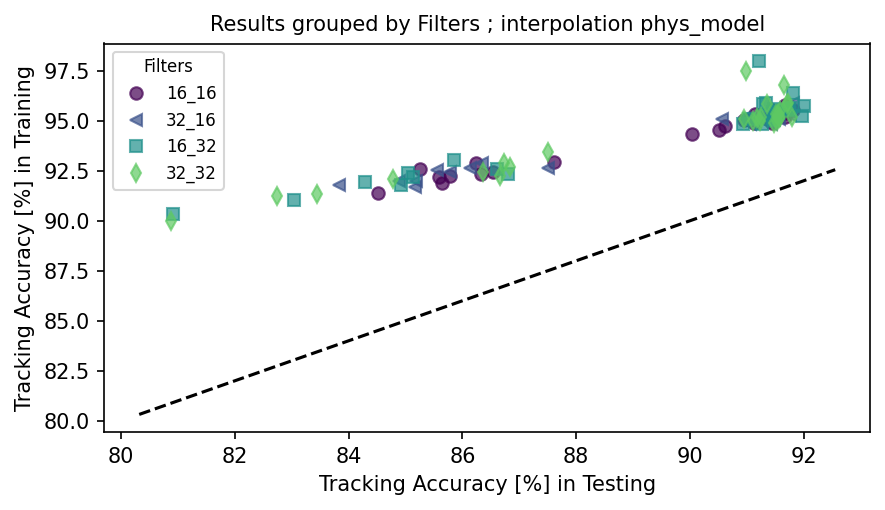

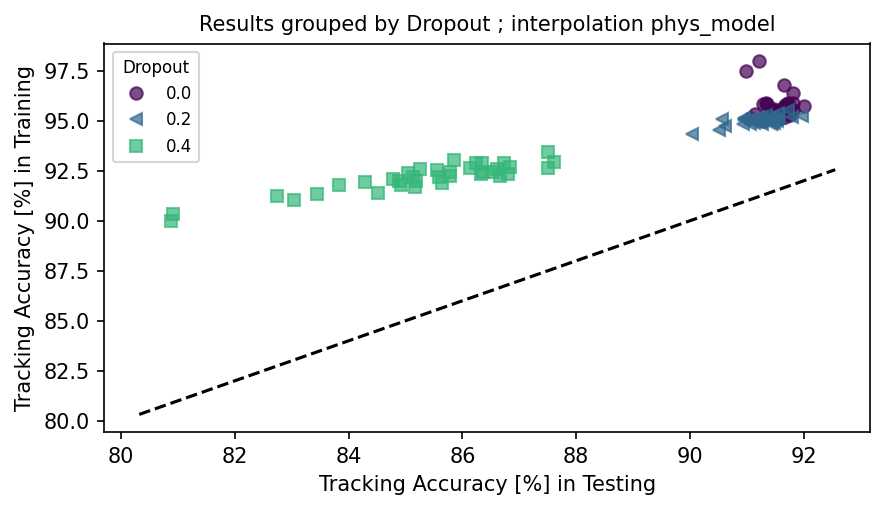

In [14]:
# Define the grouping variable and set the evaluation metrics:
group_var = 'Filters' # Grouping variable
test_col = 'Acc_Test_z' # Evaluation metric in testing dataset
train_col = 'Acc_Val_z' # Evaluation metric in validating dataset
gral_metric = 'Tracking Accuracy [%]' # General metric used in both training and testing datasets
xlabel_metric = 'Tracking Accuracy according to testing dataset [%]' # x-label in plot
stage = 'Stage5_' # Stage keyword

# Load data and see overall results:
res_S5 = {} # Initiate
for interp in interp_opts:
    if any([stage in file for file in gral_res_files[interp]]):       
        # Overall results:
        save_name = None # Choose saving name, if any
        res_S5[interp] = ML_analysis.load_results_and_overview(
            [file for file in gral_res_files[interp] if stage in file][0],
            group_var,interpolation=interp,
            eval_col=test_col,xlabel_metric=xlabel_metric,
            figsize=(6,2.5),save_name=save_name
        )

        # Training vs Testing results:
        save_name = None # Choose saving name, if any
        ML_analysis.plot_gen_test_vs_val(
            res_S5[interp],test_col=test_col,train_col=train_col,
            group_by=['Filters','Dropout'],gral_metric=gral_metric,
            interpolation=interp,figsize=(6,3.5),save_name=save_name
        )

From these plots, it's clear that a null dropout fraction (then all Dense layers have permanent working neurons) works better. The optimal numbers of filters for the first and second Convolutional layers are not clear, so let's make a choice on the dropout fraction for now:

- Keep **0 (null)** dropout fraction.
- Numbers of filters to be determined.

As the last analysis, we make a new selection based on these options and plot the Tracking accuracy range (meaning a bar that comprises all results) for each numbers of filters option, taking into account all rotational frames.


Interpolation approach: lin_approx.
Best choice (based on lowest group-score): 16_16
Lowest score for 16_16: 90.1
Highest score for 16_16: 90.8


Interpolation approach: phys_model.
Best choice (based on lowest group-score): 16_32
Lowest score for 16_32: 91.2
Highest score for 16_32: 92.0



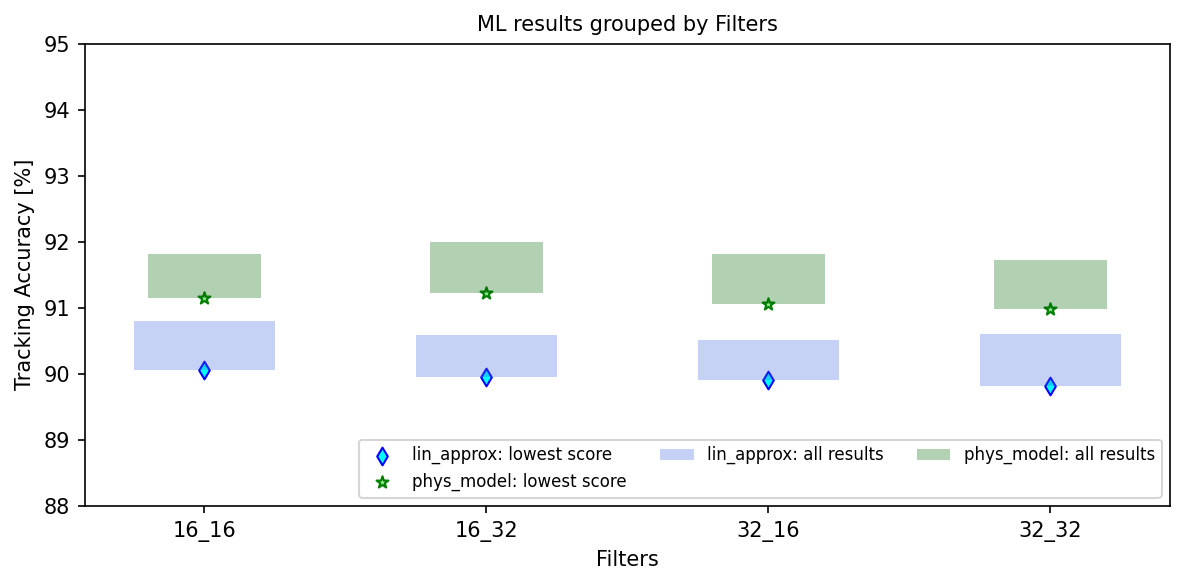

In [15]:
# Define the grouping variable and additional configuration:
group_var = 'Filters' # Grouping variable
eval_col = 'Acc_Test_z' # Column to determine sorting order
metric = 'Tracking Accuracy [%]' # Metrics used to evaluate the ML models
y_lims = [88,95] # Plot limits (tracking accuracy [%])        

# Global hyperparameters fine selection:
res_S5_selec = {} # Initiate
for interp in interp_opts:
    if interp in res_S5:
        # Conditions (select rows within dataset):
        dropout_opt = (res_S5[interp]['Dropout'] == 0)
        # Make a new dataset with only selected architectures:
        res_S5_selec[interp] = res_S5[interp][dropout_opt].reset_index()      
        
# Plot tracking accuracy:
save_name = None
ML_analysis.group_results(
    res_S5_selec,group_var,eval_col=eval_col,metric=metric,
    y_lims=y_lims,save_name=save_name,save_format='png',figsize=(8,4)    
    )       

All options for numbers of filters perform similarly well, so we choose the simplest one: 16 filters for both the first and second CNN.

**DECISION for parameters to carry on to next stages:**

* Droupout: 0.
* Filters: 16_16.

## Stage 6: size of training dataset and Data augmentation 

This stage focuses on the **size of the training dataset**, meaning how far it can be reduced at the expense of performance, and also on **data augmentation** techniques, to evaluate if the performance can be improved by synthetic data. Let's see the overall results, and the testing vs training evaluation comparison:

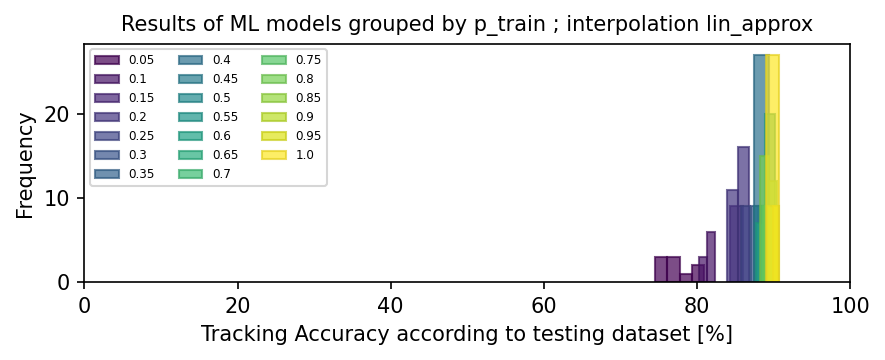

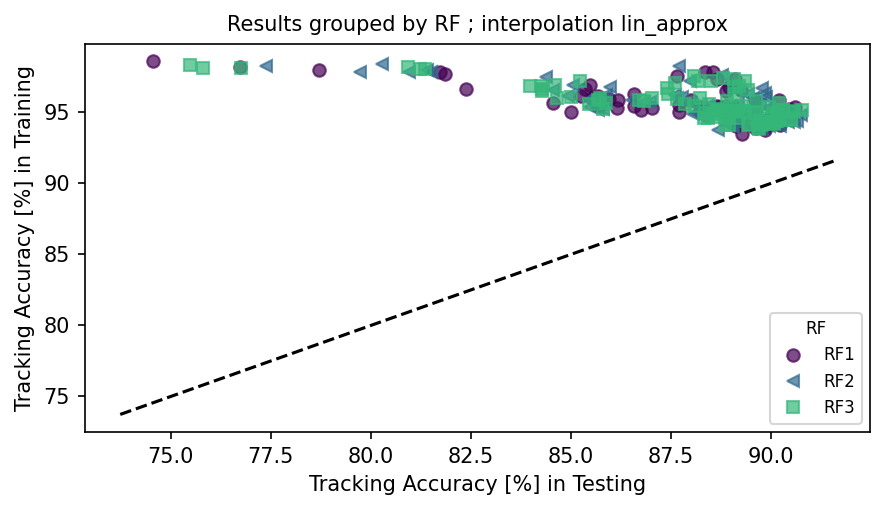

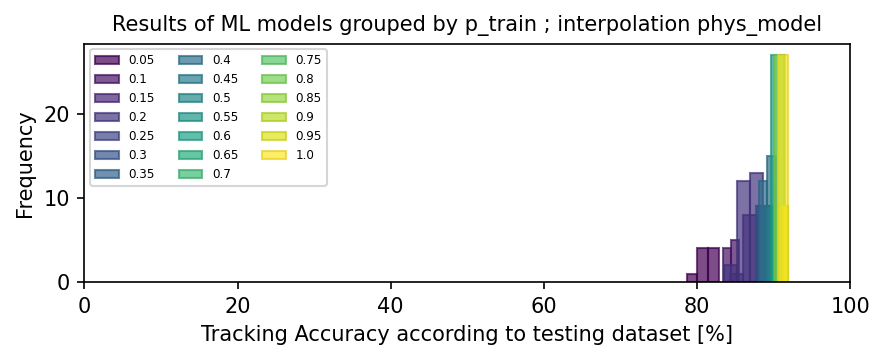

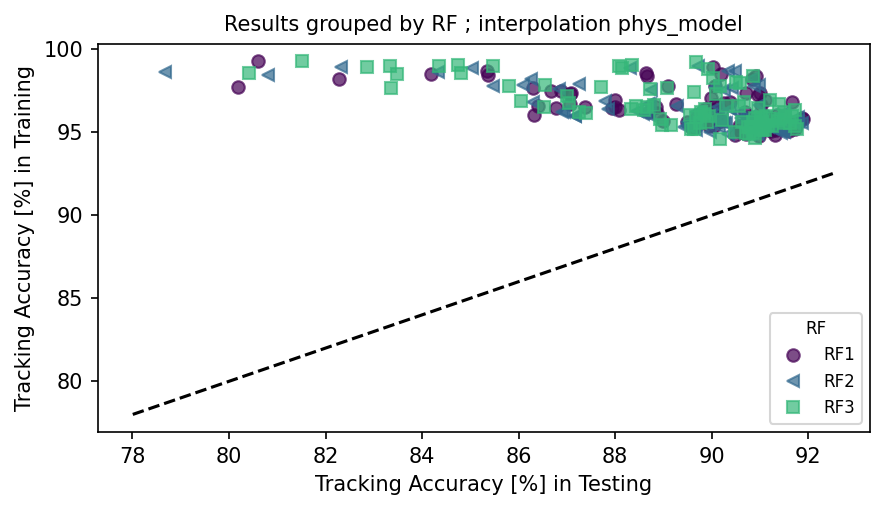

In [16]:
# Define the grouping variable and set the evaluation metrics:
group_var = 'p_train' # Grouping variable
test_col = 'Acc_Test_z' # Evaluation metric in testing dataset
train_col = 'Acc_Val_z' # Evaluation metric in validating dataset
gral_metric = 'Tracking Accuracy [%]' # General metric used in both training and testing datasets
xlabel_metric = 'Tracking Accuracy according to testing dataset [%]' # x-label in plot
stage = 'Stage6_' # Stage keyword

# Load data and see overall results:
res_S6 = {} # Initiate
for interp in interp_opts:
    if any([stage in file for file in gral_res_files[interp]]):       
        # Overall results:
        save_name = None # Choose saving name, if any
        res_S6[interp] = ML_analysis.load_results_and_overview(
            [file for file in gral_res_files[interp] if stage in file][0],
            group_var,interpolation=interp,
            eval_col=test_col,xlabel_metric=xlabel_metric,
            figsize=(6,2.5),save_name=save_name
        )

        # Training vs Testing results:
        save_name = None # Choose saving name, if any
        ML_analysis.plot_gen_test_vs_val(
            res_S6[interp],test_col=test_col,train_col=train_col,
            group_by=['RF'],gral_metric=gral_metric,
            interpolation=interp,figsize=(6,3.5),save_name=save_name
        )

This stage focused on two different aspects that can be combined:

1. **Size for the training dataset**. This is represented by the variable 'p_train': the fraction of the original dataset that is used to build a new dataset. It goes from as low to 0.05 to 1.0, meaning the complete original dataset.
2. **Data augmentation**. By creating synthetic data, we enlarge the training dataset "N_augm" number of times, by replicating the original training dataset (or a fraction 'p_train') and adding noise in the three magnetic components: "Bx_noise", "By_noise", "Bz_noise". The options for "N_augm" range from 0 (no data augmentation) to 3. The options for the mean noise intensity are 3, 10 and 20 nT.

The first study in this stage involved the **Size for the training dataset**, without any data augmentation.

The second study in this stage focused on the **Data augmentation**, using the full original training dataset (p_train=1) and playing with options for "N_augm" and the noise intensities.

Let's address the first study:

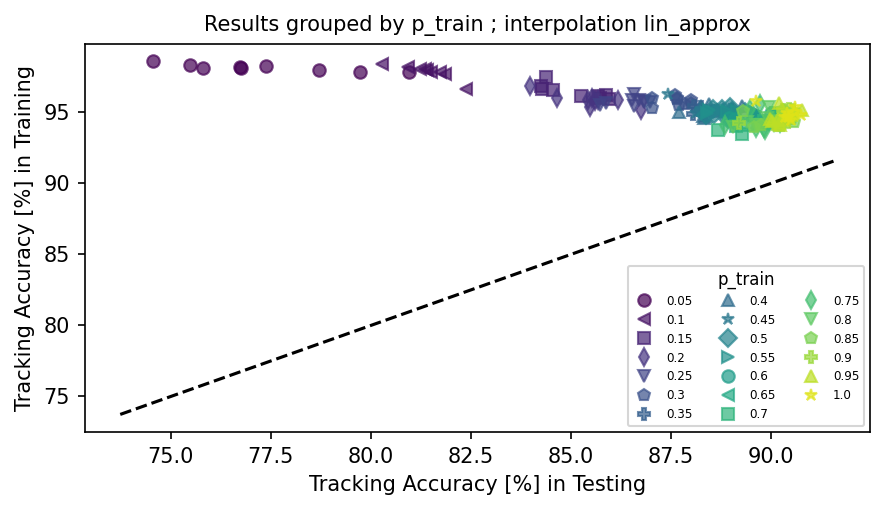

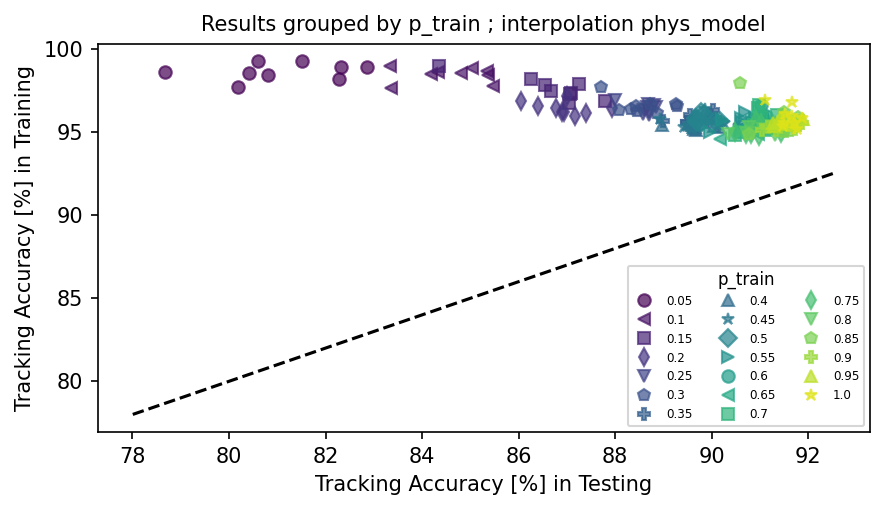

In [17]:
# Global hyperparameters fine selection:
res_S6_study1 = {} # Initiate
for interp in interp_opts:
    if interp in res_S6:
        # Conditions (select rows within dataset):
        cond_augm0 = (res_S6[interp]['N_augm'] == 0)
        # Make a new dataset with only selected architectures:
        res_S6_study1[interp] = res_S6[interp][cond_augm0].reset_index()
        
        # Training vs Testing results:
        save_name = None # Choose saving name, if any
        ML_analysis.plot_gen_test_vs_val(
            res_S6_study1[interp],test_col=test_col,train_col=train_col,
            group_by=['p_train'],gral_metric=gral_metric,
            interpolation=interp,figsize=(6,3.5),save_name=save_name
        )

As expected, the more complete the training dataset (increasing p_train) the better the ML results.

On the other hand, the best performance occurs where there is no data augmentation (N_augm=0).

Now, let's focus on the second study:

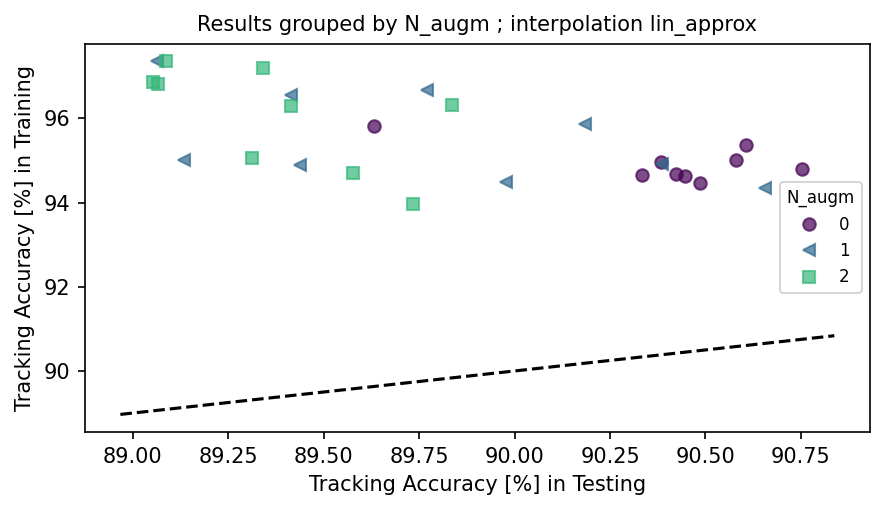

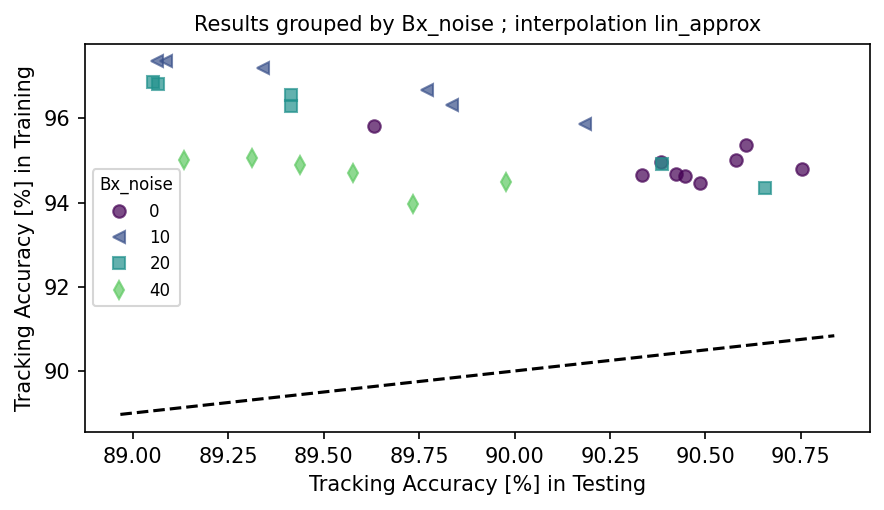

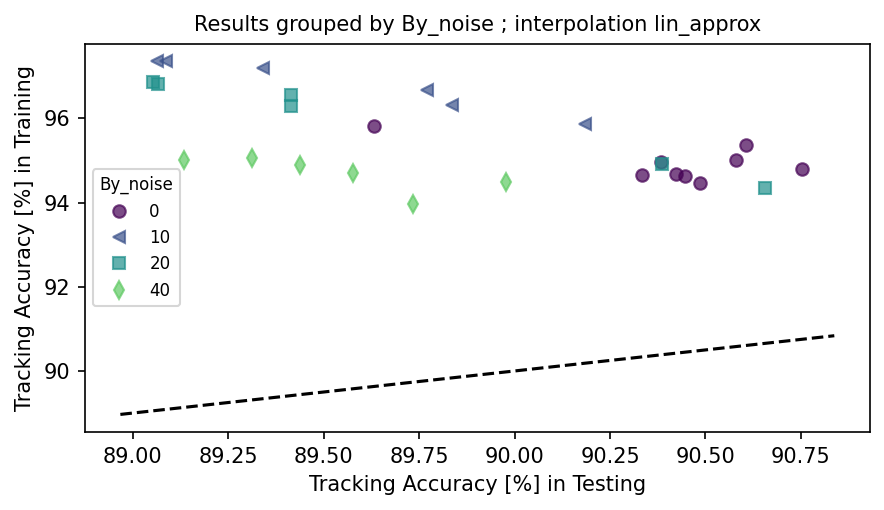

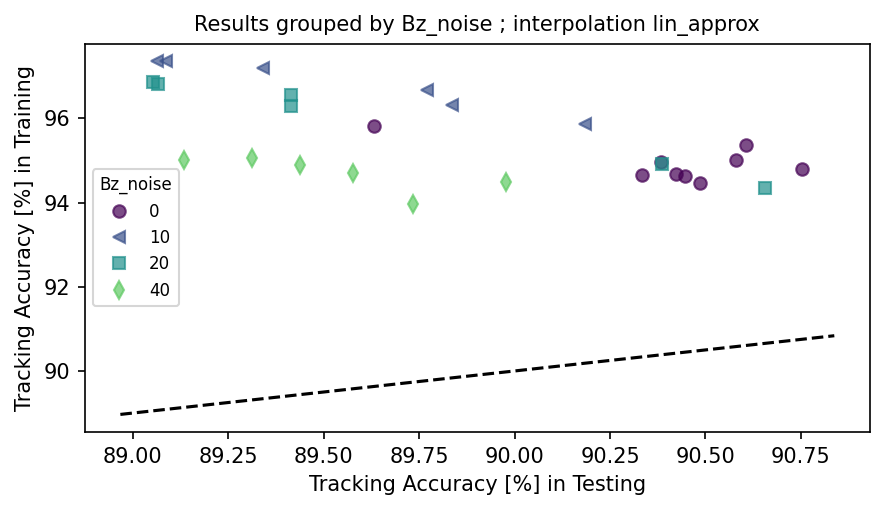

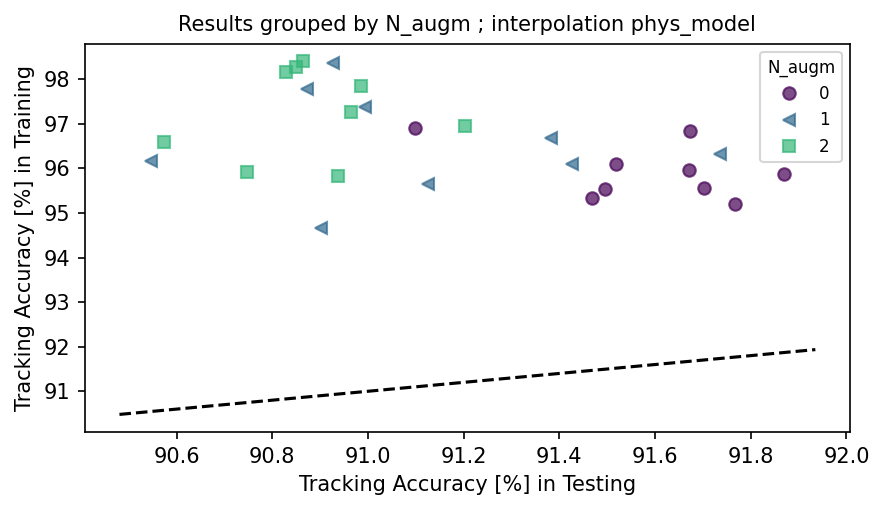

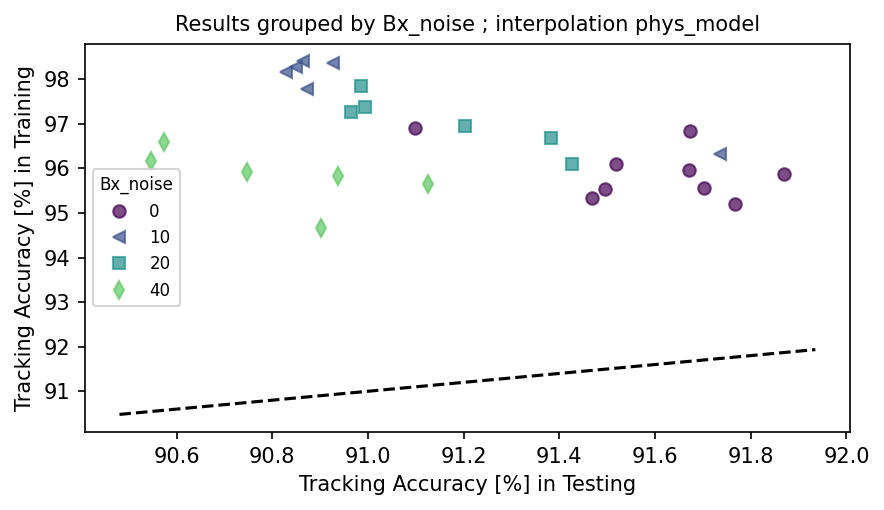

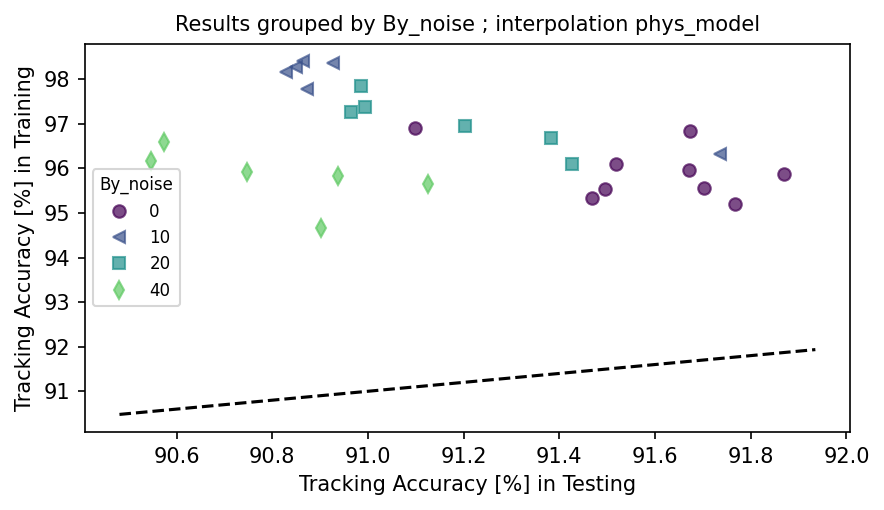

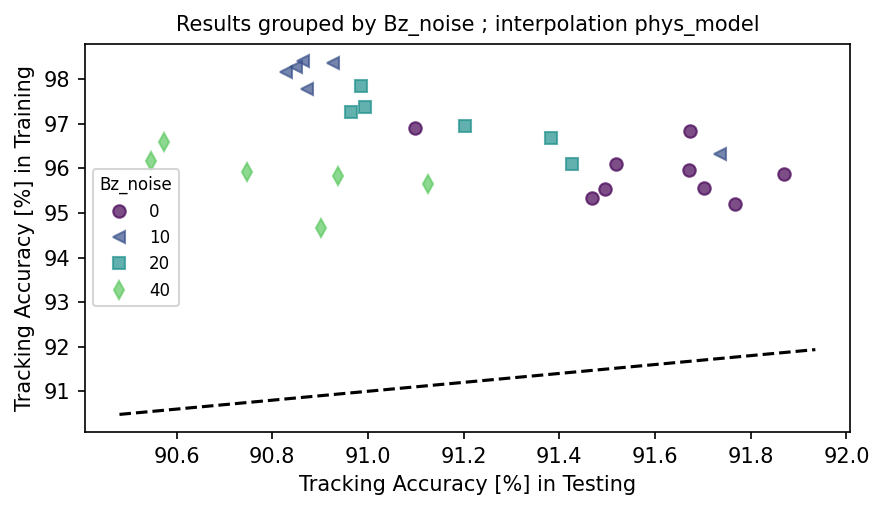

In [18]:
# Global hyperparameters fine selection:
res_S6_study2 = {} # Initiate
for interp in interp_opts:
    if interp in res_S6:
        # Conditions (select rows within dataset):
        cond_ptrain = (res_S6[interp]['p_train'] == 1)
        # Make a new dataset with only selected architectures:
        res_S6_study2[interp] = res_S6[interp][cond_ptrain].reset_index()
        
        # Training vs Testing results:
        save_name = None # Choose saving name, if any
        ML_analysis.plot_gen_test_vs_val(
            res_S6_study2[interp],test_col=test_col,train_col=train_col,
            group_by=['N_augm','Bx_noise','By_noise','Bz_noise'],
            gral_metric=gral_metric,interpolation=interp,
            figsize=(6,3.5),save_name=save_name
        )

This study confirms the previous conclusion about the data augmentation: using the original dataset is better. Regarding the noise intensity, the little exploration with the values 3, 10 and 20 nT demonstrated that it's best to use larger variations in the synthetic data (20 nT) for all magnetic components. It could be possible that higher noise intensities help to improve the performance, but so far we havent't observed any substancial improvement (much rather a performance degradation) by using data augmentation, so won't go deeper in this research direction.

Lastly, it is possible to analyze the effect of data augmentation given the fraction "p_train" of the original dataset that was used:

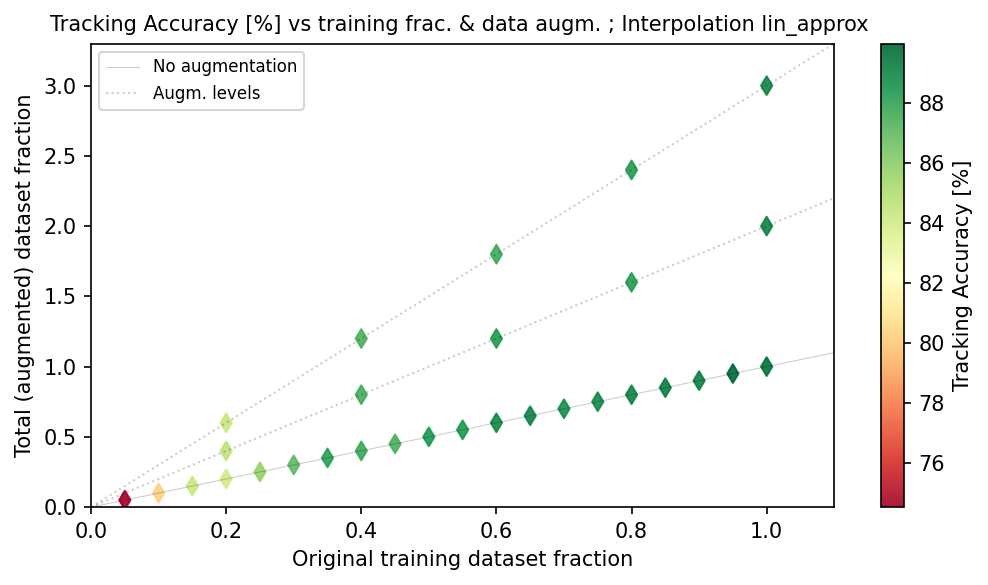

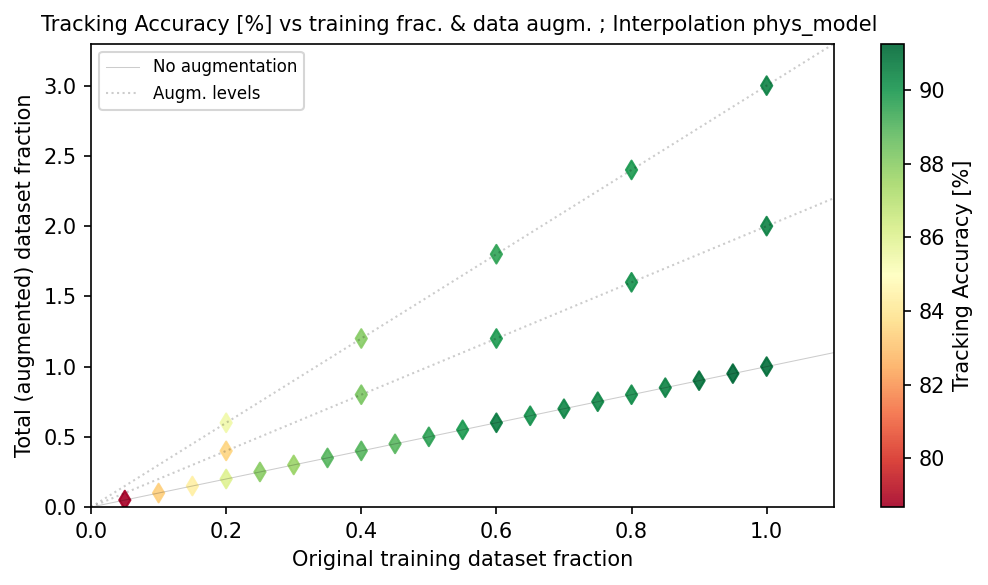

In [19]:
eval_col = 'Acc_Test_z' # Evaluation metric in testing dataset
gral_metric = 'Tracking Accuracy [%]' # General metric used in both training and testing datasets
for interp in interp_opts:
    if interp in res_S6:
        save_name = None
        ML_analysis.plot_performance_vs_Naugm_vs_ptrain(
            res_S6[interp],eval_col=eval_col,metric=gral_metric,
            interpolation=interp,save_name=save_name,
            save_format='png',figsize=(7,4)
            )

This plot captures the previous comments: the larger the original training dataset, the better for the model. Data augmentation, on the other hand, does not provide an improvement, and most of the times it just degrades the ML performance.

Finally, only using original data (no augmentation), let's plot the Tracking accuracy range (meaning a bar that comprises all results) for each fraction option, taking into account all rotational frames.


Interpolation approach: lin_approx.
Best choice (based on lowest group-score): 0.95
Lowest score for 0.95: 90.0
Highest score for 0.95: 90.8



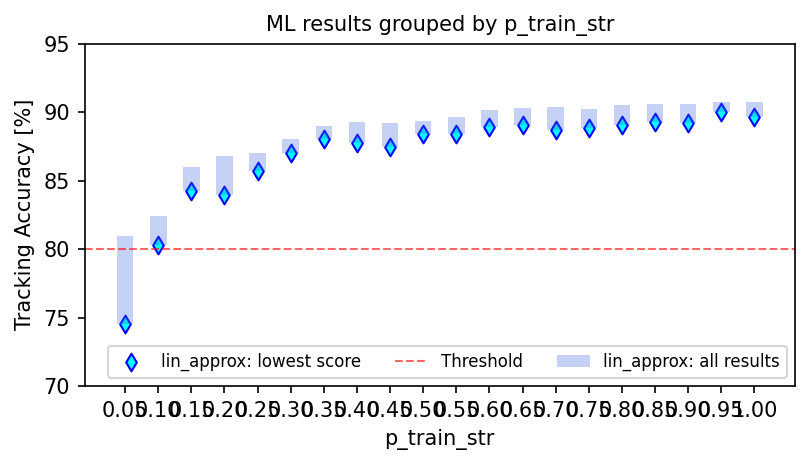

In [20]:
# Choose the approaches
approaches = ['lin_approx'] # 'lin_approx', 'phys_model'
res_S6_plot = {} # Auxiliar dictionary, only for plotting

# Define the grouping variable and additional configuration:
group_var = 'p_train' # Grouping variable
eval_col = 'Acc_Test_z' # Column to determine sorting order
metric = 'Tracking Accuracy [%]' # Metrics used to evaluate the ML models
y_lims = [70,95] # Plot limits (tracking accuracy [%])
score_thres = 80 # Threshold scoring to be displayed as a red horizontal line

# Global hyperparameters fine selection:
res_S6_selec = {} # Initiate
for interp in approaches:
    if interp in res_S6:
        # Conditions (select rows within dataset):
        augm_opt = (res_S6[interp]['N_augm'] == 0)
        # Make a new dataset with only selected architectures:
        res_S6_selec[interp] = res_S6[interp][augm_opt].reset_index()      

        # Convert grouping variable into string-type, necessary for next plot:
        res_S6_selec[interp][f'{group_var}_str'] = res_S6_selec[interp][group_var].apply(
            lambda x: '{:.2f}'.format(x))
        
# Plot tracking accuracy:
save_name = 'Images/Stage6_lin_approx' if 'phys_model' not in approaches else 'Images/Stage6_lin_approx_phys_model'
ML_analysis.group_results(
    res_S6_selec,f'{group_var}_str',eval_col=eval_col,
    score_thres=score_thres,metric=metric,y_lims=y_lims,
    save_name=save_name,save_format='svg',figsize=(5.5,3.2)    
    )       

**DECISION for parameters to carry on to next stages:**

* No data augmentation.
* Use the entire training dataset.

## Stage 7: Final model, evaluation in many rotational frames

This is the **final stage**, in which the **best ML architecture** is evaluated in many rotational frames.

In the following, we study the two different metrics of this project:

1. Parking accuracy: exclusive evaluation of the parking levels, which are the ground truth.
2. Tracking accuracy: evaluation of the entire set of predictions, including the parking levels as well as the interpolated data.

In both cases, we use a Z-threshold parameter, which determines how far each prediction can be from the ground truth value (or interpolated value) to be considered successful.

First, we load the predictions:

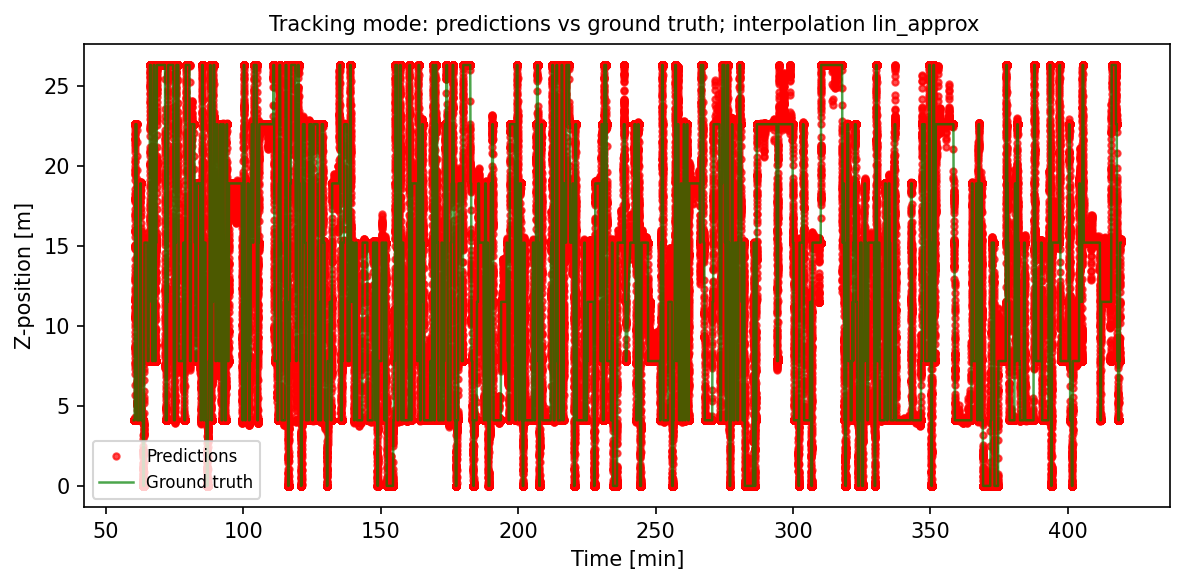

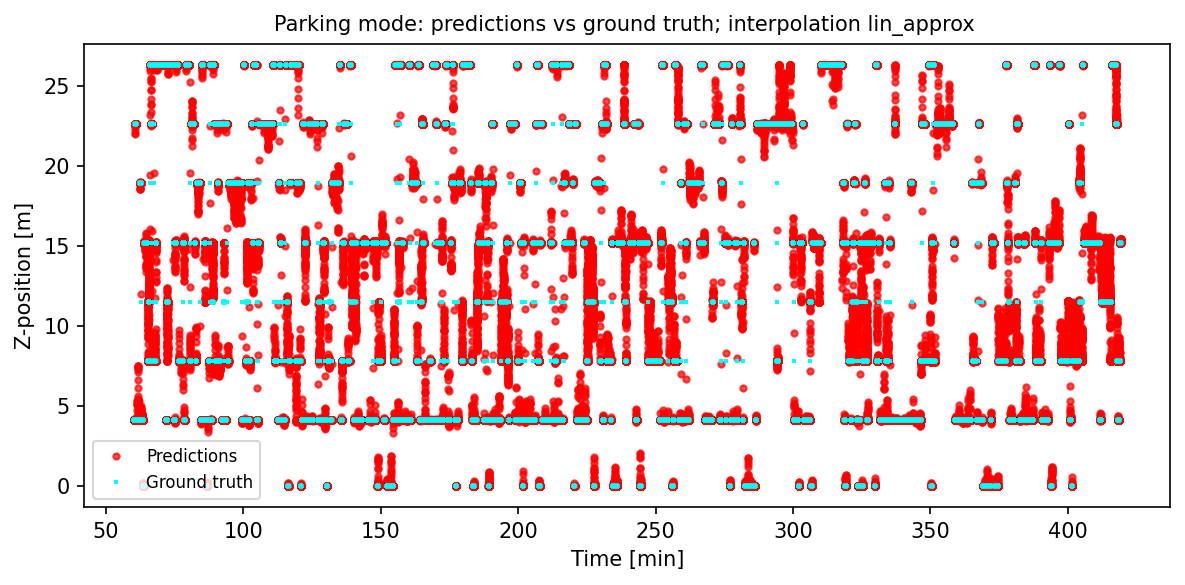

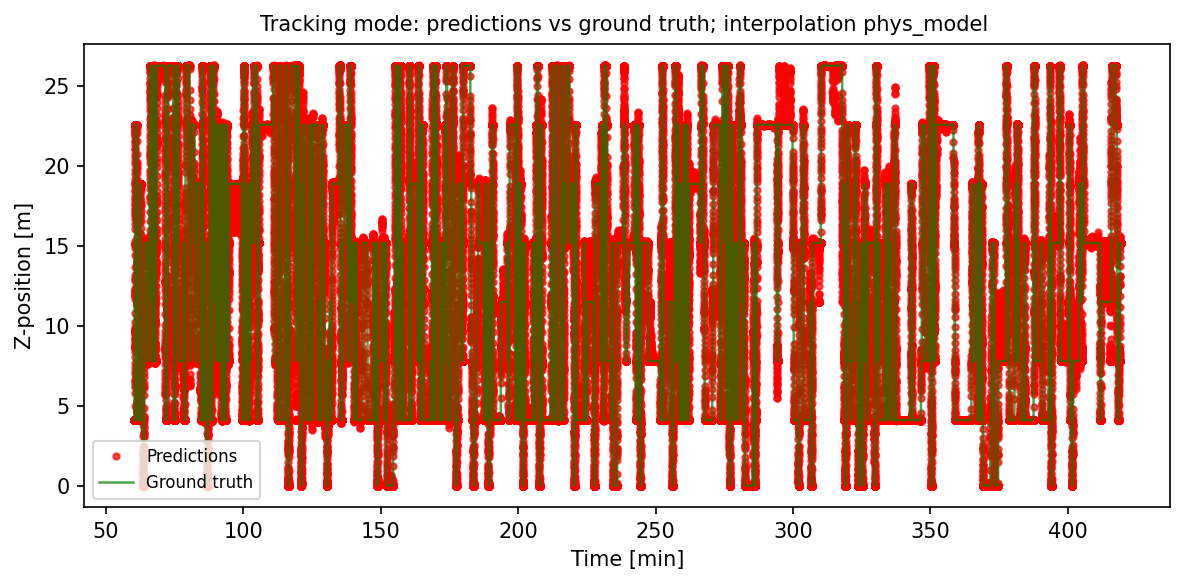

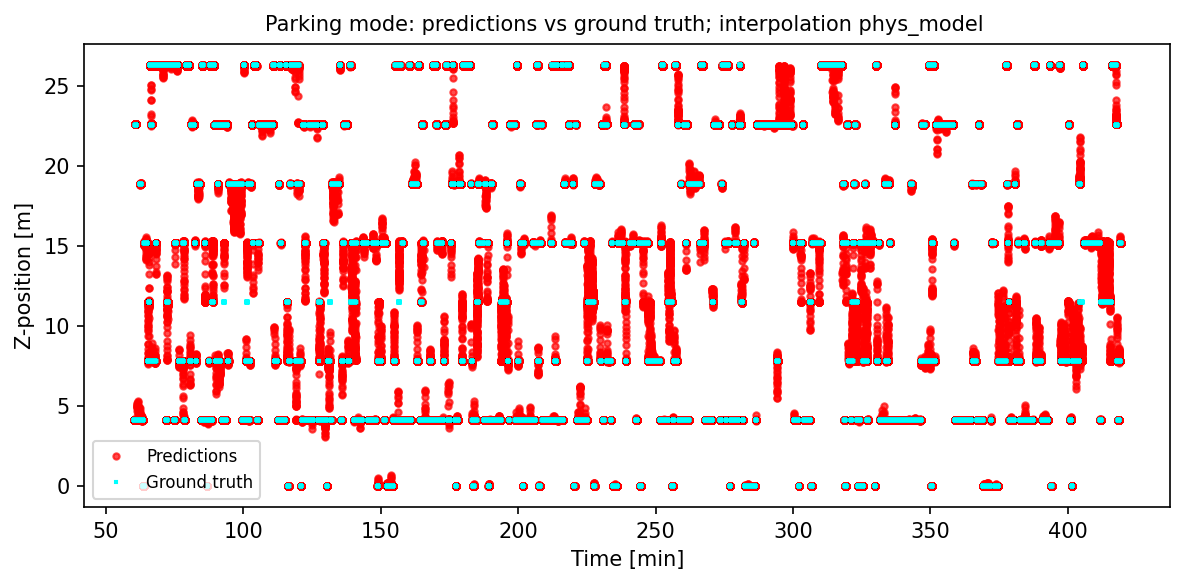

In [21]:
# Load data and see results for parking and tracking accuracies using a 1-meter threshold:
preds_park_S7, preds_track_S7 = {}, {} # Initiate predictions 
for interp in interp_opts:
    if files_final_stage[interp]:
        # Load parking and tracking predictions:
        preds_park_S7[interp], preds_track_S7[interp] = ML_analysis.load_preds(
            files_final_stage[interp],plot_sample=True,
            interpolation=interp,figsize=(8,4))

Using a fixed Z-threshold parameter equal to 1 meter, we evaluate both parking and tracking accuracies. In addition, the parking accuracy is computed level by level.


--------- Interpolation approach: lin_approx ---------

Overall PARKING accuracy: 94.94%

Overall TRACKING accuracy: 88.99%



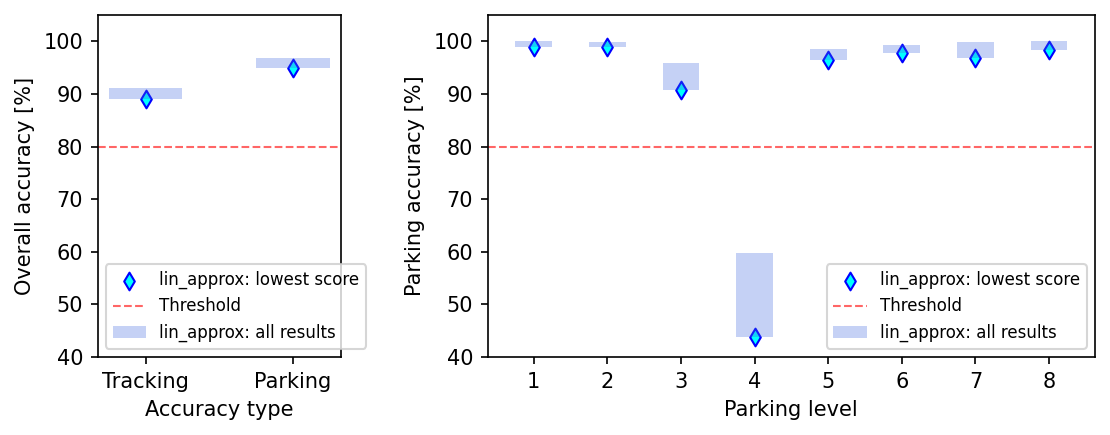

In [22]:
# Configuration:
figsize = (7.5,3)
score_thres = 80 # Accuracy threshold [%]
z_tol = 1 # Position tolerance to evaluate correct predictions [m]
y_lims = [40,105] # Accuracy boundaries [%]

# Select data:
approaches = ['lin_approx'] # 'phys_model' and/or 'lin_approx'
preds_park_S7_selec, preds_track_S7_selec = {}, {}
for interp in approaches:
    preds_park_S7_selec[interp] = preds_park_S7[interp]
    preds_track_S7_selec[interp] = preds_track_S7[interp]

# Analysis and plots:
save_name = 'Images/Stage7_lin_approx_tol1m' if 'phys_model' not in approaches else 'Images/Stage7_lin_approx_phys_model_tol1m'
ML_analysis.analyze_acc_fixed_Ztol(
    preds_park_S7_selec,preds_track_S7_selec,z_tol=z_tol,
    score_thres=score_thres,y_lims=y_lims,
    save_name=save_name,save_format='svg',figsize=figsize)

Repeat the analyzis with a 4-meter tolerance:


--------- Interpolation approach: lin_approx ---------

Overall PARKING accuracy: 99.96%

Overall TRACKING accuracy: 99.92%



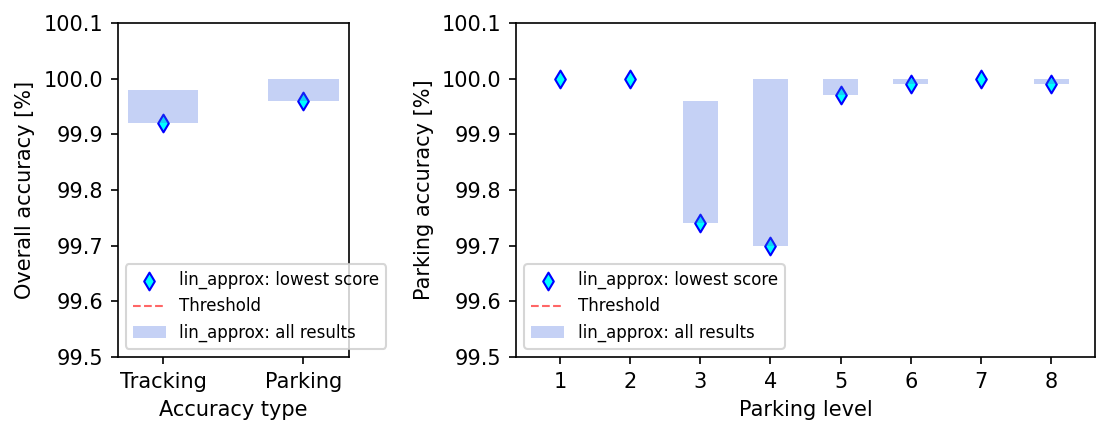

In [23]:
# Configuration:
figsize = (7.5,3)
score_thres = 80 # Accuracy threshold [%]
z_tol = 4 # Position tolerance to evaluate correct predictions [m]
y_lims = [99.5,100.1]#[40,105] # Accuracy boundaries [%]

# Select data:
approaches = ['lin_approx'] # 'phys_model' and/or 'lin_approx'
preds_park_S7_selec, preds_track_S7_selec = {}, {}
for interp in approaches:
    preds_park_S7_selec[interp] = preds_park_S7[interp]
    preds_track_S7_selec[interp] = preds_track_S7[interp]

# Analysis and plots:
save_name = 'Images/Stage7_lin_approx_tol4m' if 'phys_model' not in approaches else 'Images/Stage7_lin_approx_phys_model_tol4m'
ML_analysis.analyze_acc_fixed_Ztol(
    preds_park_S7_selec,preds_track_S7_selec,z_tol=z_tol,
    score_thres=score_thres,y_lims=y_lims,
    save_name=save_name,save_format='svg',figsize=figsize)

Plot the input magnetic predictors, predicted Z-positions and ground truth for a segment of the testing dataset in a single rotational frame:

Chosen frame: pol90_azim0


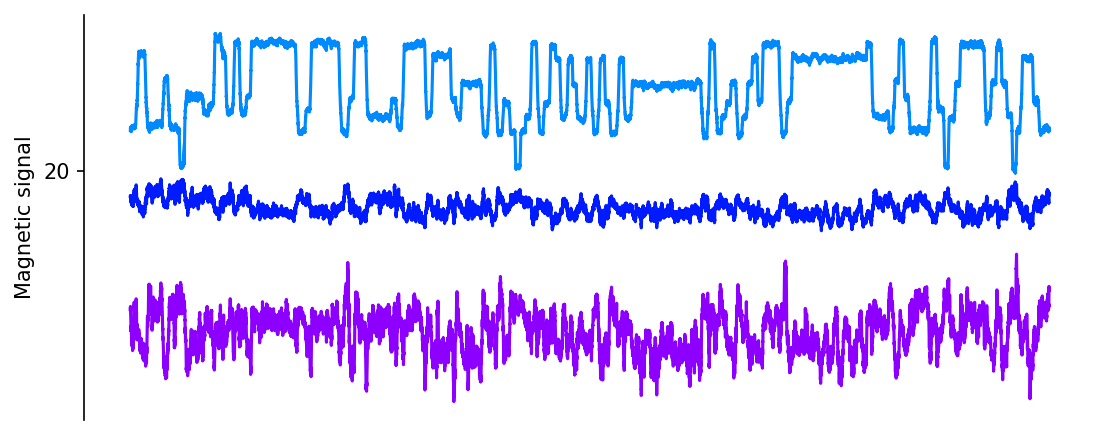

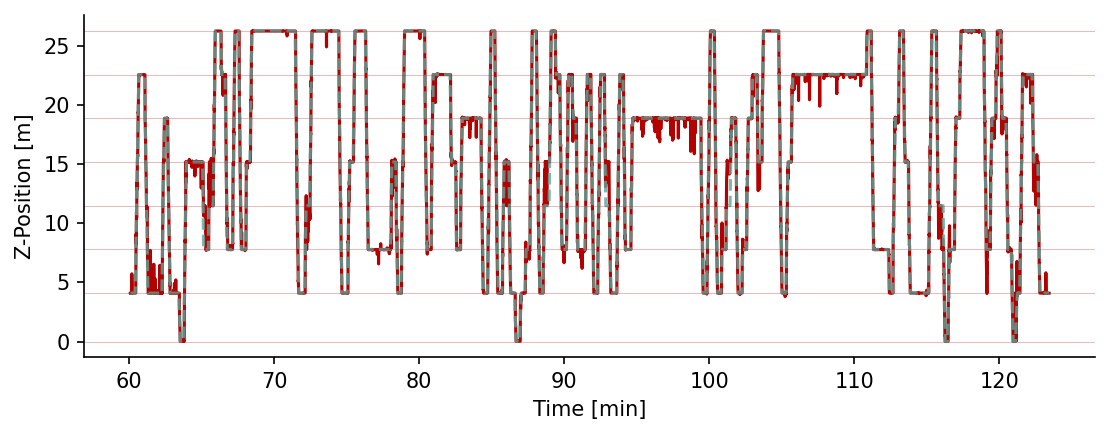

In [24]:
preds_track = preds_track_S7['lin_approx']
mag_files = ['../Data/lin_approx_data_zAut_segm2.csv','../Data/lin_approx_data_zAut_segm3.csv']
RF_number = 18
i_lims = [0,38000]
figsize = (7.5,3)
save_name = 'Images/Final_data_preds'

ML_analysis.plot_preds_single_RF(
    preds_track,mag_files,RF_number=RF_number,i_lims=i_lims,
    save_name=save_name,save_format='svg',figsize=figsize)

Analyze the tracking accuracy as a function of the Z-tolerance value, from a very low tolerance (1 cm) to the maximum tolerance required to identify unequivocally the closest parking level (2 m).

Analyzing Interpolation approach: lin_approx.
Critical Z-tolerance: 0.2972m, with 80.11% tracking accuracy
Tracking accuracy with 1-meter tolerance: 88.99%
Tracking accuracy with 2-meter tolerance: 94.97%


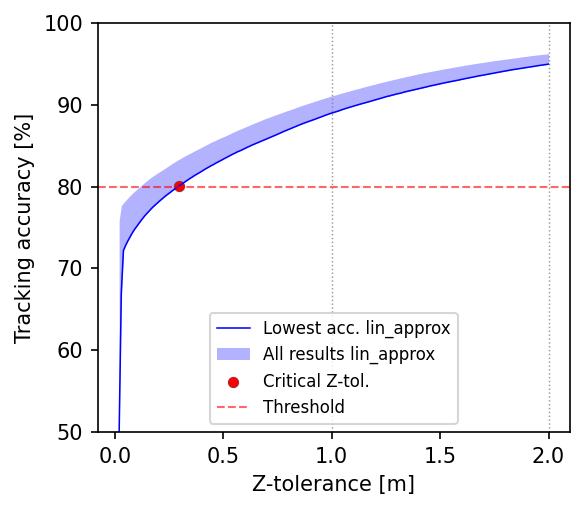

In [25]:
# Prepare array with Z-tolerance values, and additional configuration:
z_tols = np.linspace(0.02,2.0,201) # Z-tolerance values [m]
score_thres = 80 # Tracking accuracy threshold [%]
y_lims = [50,100] # Tracking accuracy boundaries [%]
save_name = 'Images/Track_acc_Vs_Ztol_lin_approx'

acc_min, acc_max = ML_analysis.analyze_acc_track_vs_Ztol(
    preds_track_S7_selec,z_tols=z_tols,score_thres=score_thres,
    y_lims=y_lims,save_name=save_name,save_format='svg',figsize=(4,3.5)
    )

# Summarize results:
i_acc80 = np.argmax(acc_min['lin_approx']>80)
i_z1m = np.argmax(z_tols>=1)
i_z2m = np.argmax(z_tols>=2)
print(f'Critical Z-tolerance: {z_tols[i_acc80]}m, with {acc_min['lin_approx'][i_acc80]}% tracking accuracy')
print(f'Tracking accuracy with 1-meter tolerance: {acc_min['lin_approx'][i_z1m]}%')
print(f'Tracking accuracy with 2-meter tolerance: {acc_min['lin_approx'][i_z2m]}%')

Repeat the analysis for both linear approximation and physical model approaches:

Analyzing Interpolation approach: lin_approx.
Analyzing Interpolation approach: phys_model.

----- Interpolation: lin_approx -----

Critical Z-tolerance: 0.2972m, with 80.11% tracking accuracy.
Tracking accuracy with 1-meter tolerance: 88.99%.
Tracking accuracy with 2-meter tolerance: 94.97%.

----- Interpolation: phys_model -----

Critical Z-tolerance: 0.2972m, with 82.97% tracking accuracy.
Tracking accuracy with 1-meter tolerance: 90.18%.
Tracking accuracy with 2-meter tolerance: 94.9%.


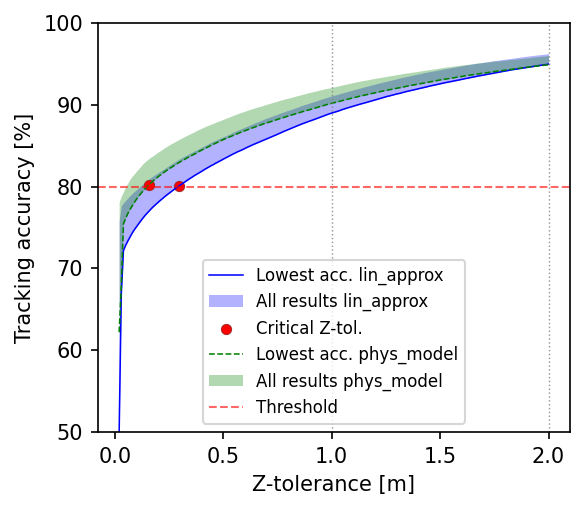

In [27]:
# Prepare array with Z-tolerance values, and additional configuration:
z_tols = np.linspace(0.02,2.0,201) # Z-tolerance values [m]
score_thres = 80 # Tracking accuracy threshold [%]
y_lims = [50,100] # Tracking accuracy boundaries [%]
save_name = 'Images/Track_acc_Vs_Ztol_both_approaches'

acc_min, acc_max = ML_analysis.analyze_acc_track_vs_Ztol(
    preds_track_S7,z_tols=z_tols,score_thres=score_thres,
    y_lims=y_lims,save_name=save_name,save_format='svg',figsize=(4,3.5)
    )

# Summarize results:
for approach in ['lin_approx','phys_model']:
    print(f'\n----- Interpolation: {approach} -----')
    i_acc80 = np.argmax(acc_min['lin_approx']>80)
    i_z1m = np.argmax(z_tols>=1)
    i_z2m = np.argmax(z_tols>=2)
    print(f'\nCritical Z-tolerance: {z_tols[i_acc80]}m, with {acc_min[approach][i_acc80]}% tracking accuracy.')
    print(f'Tracking accuracy with 1-meter tolerance: {acc_min[approach][i_z1m]}%.')
    print(f'Tracking accuracy with 2-meter tolerance: {acc_min[approach][i_z2m]}%.')

Make a polar plot for the tracking accuracy as a function of both azimuth and polar angles of each rotational frame:

Minimum tracking accuracy: 88.99%
Maximum tracking accuracy: 91.09%
Minimum tracking accuracy: 90.18%
Maximum tracking accuracy: 92.12%


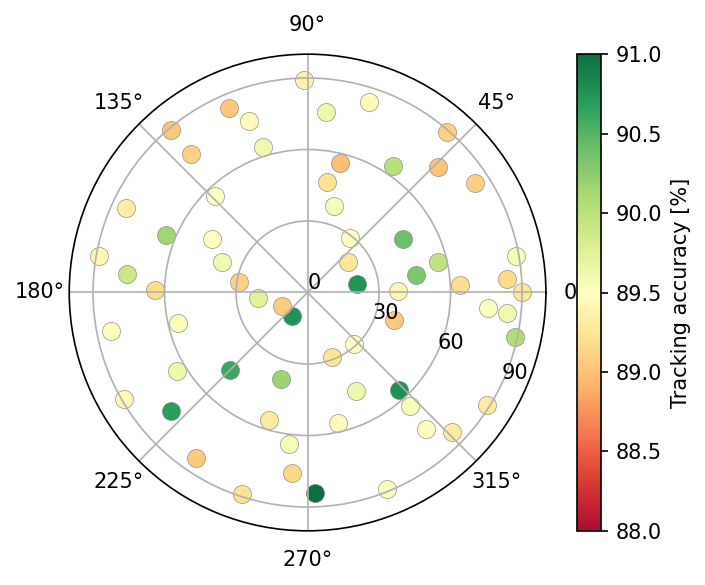

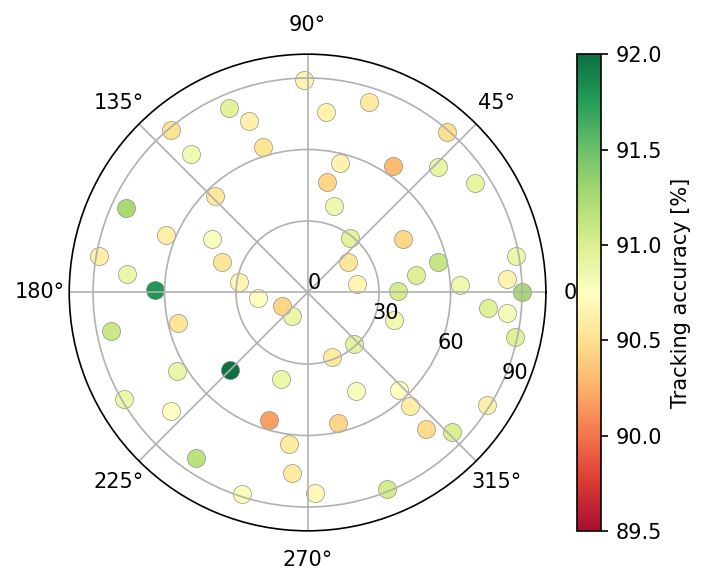

In [28]:
# Choose position-tolerance:
z_tol = 1 # [m]

# Make plots:
for approach in ['lin_approx','phys_model']:
    save_name = f'Images/Tracking_accuracy_Vs_RF_{approach}_Ztol{z_tol}m'
    acc_lims = [88.0,91.0] if approach=='lin_approx' else [89.5,92.0] # Tracking accuracy boundaries [%]    
    ML_analysis.map_acc_track_vs_RF(
        preds_track_S7[approach],
        z_tol=z_tol,
        acc_lims=acc_lims,
        save_name=save_name,
        save_format='svg',
        figsize=(5,4)
        )